# Final Project
Brenda Wang

In [23]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

from sklearn.datasets import fetch_20newsgroups
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
from collections import defaultdict
from copy import deepcopy
from pprint import pprint

from gensim import corpora
from gensim import models
from gensim.models import doc2vec

import csv
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA 
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

## 1. Preprocessing and visualizing data
Preprocessing will include clean data, lower docs, tokenization, filtering, etc. The final goal of preprocessing is to build a vocab with the given corpus, so that you could vectorize your docs with bag-of-words.

### Fetch the raw data from the 20newsgroup corpora

In [24]:
# we load both training and testing splits as our final project mainly focuses on the unsupervised setting. 
raw_dataset = fetch_20newsgroups(subset='all', shuffle=False)
print(raw_dataset.data[0])

From: cubbie@garnet.berkeley.edu (                               )
Subject: Re: Cubs behind Marlins? How?
Article-I.D.: agate.1pt592$f9a
Organization: University of California, Berkeley
Lines: 12
NNTP-Posting-Host: garnet.berkeley.edu


gajarsky@pilot.njin.net writes:

morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)

       This season so far, Morgan and Guzman helped to lead the Cubs
       at top in ERA, even better than THE rotation at Atlanta.
       Cubs ERA at 0.056 while Braves at 0.059. We know it is early
       in the season, we Cubs fans have learned how to enjoy the
       short triumph while it is still there.



In [25]:
# Sklearn already implements an interface for this step.
dataset = fetch_20newsgroups(subset='all', shuffle=False, remove=('headers', 'footers', 'quotes'))
print(dataset.data[0])


morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)


In [26]:
corpus = dataset.data # save as the raw docs
gnd_labels = dataset.target # labels for clustering evaluation or supervised tasks
print(len(corpus), len(gnd_labels))
print(gnd_labels)
print(dataset.target_names)
num_topics = len(dataset.target_names)

18846 18846
[ 9  4 11 ...  4  6  7]
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


### Clean the raw data

In [27]:
# Let's show the first 10 documents
for i in range(10):
    doc = corpus[i]
    category = dataset.target_names[gnd_labels[i]]
    print("The {}-th document sent by {}: {}".format(i+1, category, doc))
    print("==================================================\n")

The 1-th document sent by rec.sport.baseball: 
morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)

The 2-th document sent by comp.sys.mac.hardware: Well, I just got my Centris 610 yesterday.  It took just over two 
weeks from placing the order.  The dealer (Rutgers computer store) 
appologized because Apple made a substitution on my order.  I ordered
the one without ethernet, but they substituted one _with_ ethernet.
He wanted to know if that would be "alright with me"!!!  They must
be backlogged on Centri w/out ethernet so they're just shipping them
with!  

	Anyway, I'm very happy with the 610 with a few exceptions.  
Being nosy, I decided to open it up _before_ powering it on for the first
time.  The SCSI cable to the hard drive was only partially connected
(must have come loose in shipping).  No big deal, but I would have been
pissed if I tried to 

### Terminology

corpus = collection of docs where each doc is the original string of words

pp_corpus = preprocessed corpus -> collection of docs where each doc is list of tokenized words

BoW_corpus = collection of docs where each doc is list of tuples representing (tokenID, number of times token appears in that doc) 

vocab_v0 = all unique tokens in 20news corpus

vocab_v1 = corpus of tokens with freq >1

vocab_v2 = corpus of top 2000 by freq tokens

### Build vocab

preprocess words + make corpus1 + stats

['morgan', 'guzman', 'era', 'run', 'higher', 'year', 'cub', 'idiot', 'pitch', 'harkei', 'hibbard', 'castillo', 'won', 'good', 'think', 'stud', 'pitcher']

Number of docs:  18846

pp_corpus statistics
Min doc length:  0
Max doc length:  6199
Mean doc length:  81.87583572110793
Standard deviation of doc length:  245.18799457266107


Text(0.5, 1.0, 'Document Length')

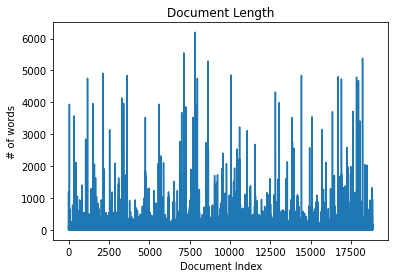

In [28]:
# Let's first get a new corpus by using one tokenization method above

# using gensim's preprocess_string
# corpus = corpus[:1000]
pp_corpus = [preprocess_string(doc) for doc in corpus]
print(pp_corpus[0]) 
print("\nNumber of docs: ", len(pp_corpus))

# get number of words per doc
word_count = list()
word_count = [len(doc) for doc in pp_corpus]

print("\npp_corpus statistics")
print("Min doc length: ", min(word_count))
print("Max doc length: ", max(word_count))
print("Mean doc length: ", np.mean(word_count))
print("Standard deviation of doc length: ", np.std(word_count))

plt.plot(word_count)
plt.xlabel("Document Index")
plt.ylabel("# of words")
plt.title("Document Length")

### 1.a Manually make freqs dictionary

In [29]:
# Manually make a frequency dictionary w/ word:frequency

# build the vocab 
freqs_manual = defaultdict(int)

# pp_corpus is preprocessed corpus -> a list of docs where each doc is a list of tokens/words
for doc in pp_corpus:
    for w in doc: 
        freqs_manual[w] += 1
        
#freqs_manual

print("Number of unique words: ", len(freqs_manual)) 
vocab = [w for w in freqs_manual if freqs_manual[w]>1]
print("Number of words with frequency>1: ", len(vocab)) 

{k: v for k, v in 
 sorted(freqs_manual.items(), key=lambda item: item[1],reverse=True)}


Number of unique words:  68128
Number of words with frequency>1:  34712


{'like': 7356,
 'peopl': 6495,
 'know': 6456,
 'us': 6080,
 'time': 6057,
 'think': 5571,
 'new': 5109,
 'work': 4712,
 'max': 4693,
 'year': 4344,
 'file': 4005,
 'want': 3993,
 'good': 3985,
 'look': 3850,
 'right': 3801,
 'wai': 3760,
 'need': 3726,
 'thing': 3711,
 'problem': 3697,
 'god': 3593,
 'window': 3478,
 'edu': 3387,
 'program': 3292,
 'post': 3131,
 'run': 3075,
 'come': 3045,
 'point': 3018,
 'includ': 2967,
 'question': 2940,
 'believ': 2891,
 'said': 2825,
 'state': 2734,
 'mean': 2718,
 'number': 2682,
 'read': 2659,
 'differ': 2645,
 'try': 2592,
 'drive': 2579,
 'help': 2571,
 'gener': 2569,
 'inform': 2546,
 'bit': 2475,
 'imag': 2444,
 'dai': 2443,
 'game': 2421,
 'thank': 2412,
 'mail': 2333,
 'person': 2320,
 'support': 2318,
 'start': 2311,
 'follow': 2288,
 'set': 2279,
 'go': 2258,
 'ask': 2242,
 'case': 2238,
 'reason': 2205,
 'avail': 2204,
 'govern': 2176,
 'com': 2148,
 'kei': 2119,
 'line': 2100,
 'power': 2086,
 'list': 2063,
 'control': 2054,
 'data': 

Text(0, 0.5, 'Count')

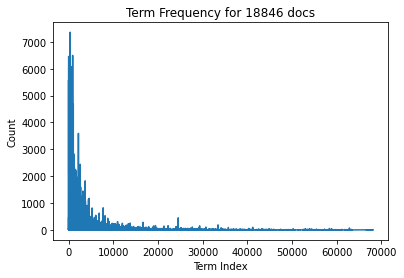

In [30]:
# visualize term frequency distribution 
plt.plot([freqs_manual[i] for i in freqs_manual])
plt.title(f"Term Frequency for {len(corpus)} docs")
plt.xlabel("Term Index")
plt.ylabel("Count")

### 1.b use gensim.corpora to get frequency stats

In [31]:
# A more efficient way to get frequencies is to use gensim.corpora

# genshin.coropora.Dictionary() converts corpus to list of vectors
vocab_v0 = corpora.Dictionary(pp_corpus)

print(vocab_v0) # key=index aka token_id, value=token
print(type(vocab_v0))


pprint(vocab_v0.token2id) #prettyprint sorted value : key (its index)

Dictionary(68128 unique tokens: ['castillo', 'cub', 'era', 'good', 'guzman']...)
<class 'gensim.corpora.dictionary.Dictionary'>
{'\x02ubject': 62729,
 'a': 22870,
 'aa': 12657,
 'aaa': 8381,
 'aaaaa': 55120,
 'aaaaaaaaaaaa': 16546,
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggg': 49797,
 'aaaaarrrrgh': 61868,
 'aaaall': 67325,
 'aaack': 59831,
 'aaaggghhh': 54488,
 'aaah': 20093,
 'aaahh': 12477,
 'aaahhhh': 49523,
 'aaai': 49130,
 'aaaread': 58840,
 'aac': 67382,
 'aacc': 49064,
 'aachen': 30224,
 'aacvkc': 29466,
 'aaer': 67433,
 'aagain': 67135,
 'aah': 49671,
 'aai': 63702,
 'aaj': 63703,
 'aalac': 51335,
 'aalmchgur': 29467,
 'aaltern': 5332,
 'aam': 35176,
 'aamaz': 45978,
 'aamir': 1631,
 'aamk': 63704,
 'aammmaaaazzzzzziinnnnggggg': 39686,
 'aamrl': 12464,
 'aan': 23832,
 'aanbieden': 47923,
 'aand': 57041,
 'aanerud': 33181,
 'aangeboden': 42449,
 'aangegeven': 23833,
 'aangezien': 47924,
 'aantal': 23834,
 'aao': 12658,
 'aaoepp': 15861,
 'a

 'allakhverdiyev': 4641,
 'allan': 18295,
 'allant': 10733,
 'allatini': 19432,
 'alldefin': 60034,
 'alleen': 47927,
 'alleg': 2363,
 'allegedli': 1746,
 'alleghani': 43134,
 'allegheni': 3533,
 'allegi': 8521,
 'allegli': 49378,
 'allegor': 14542,
 'allegori': 31611,
 'allegra': 42824,
 'allegro': 15867,
 'allei': 3991,
 'alleiat': 44684,
 'allel': 29336,
 'allelon': 59413,
 'allem': 43823,
 'allemagn': 63001,
 'allen': 1481,
 'allendorf': 55001,
 'allentown': 32746,
 'allerg': 12334,
 'allergi': 6314,
 'allergist': 34250,
 'alleri': 34251,
 'allerton': 39078,
 'allevi': 10175,
 'allez': 11342,
 'allgeier': 37316,
 'allgemein': 20919,
 'alli': 2364,
 'allianc': 2365,
 'alliant': 15868,
 'allidjqq': 41313,
 'allig': 32442,
 'allign': 28982,
 'allin': 60356,
 'allinclud': 60035,
 'allison': 54332,
 'allist': 29107,
 'alllist': 40618,
 'alllth': 67406,
 'allmartin': 39358,
 'allmichael': 30403,
 'allnet': 58767,
 'alloc': 13188,
 'allocal': 30627,
 'allocat': 20675,
 'allocnamedcolor': 

 'arocha': 34447,
 'arog': 44814,
 'aroma': 55847,
 'aromat': 38911,
 'aron': 55995,
 'aror': 61957,
 'aros': 14052,
 'aroun': 53567,
 'around': 18848,
 'arounf': 50612,
 'aroung': 67497,
 'arous': 24300,
 'arp': 32649,
 'arpa': 25893,
 'arpanet': 47415,
 'arperd': 33189,
 'arpt': 51366,
 'arptim': 68058,
 'arqoub': 53699,
 'arr': 49566,
 'arrai': 10177,
 'arraing': 16517,
 'arrang': 2378,
 'arraymax': 68037,
 'arrear': 49609,
 'arrearag': 49610,
 'arreno': 55703,
 'arrenomanei': 67869,
 'arres': 42034,
 'arrest': 1748,
 'arreste': 17228,
 'arrevola': 48971,
 'arrgen': 57920,
 'arrgggghhhh': 49499,
 'arrghhh': 60037,
 'arrhythmia': 24200,
 'arri': 49134,
 'arrisen': 45195,
 'arriv': 2379,
 'arrizen': 22308,
 'arrl': 6277,
 'arrlth': 49567,
 'arrog': 5508,
 'arrogantli': 54998,
 'arrognac': 7368,
 'arromde': 29381,
 'arromdian': 19434,
 'arros': 52818,
 'arround': 23786,
 'arrow': 8752,
 'arrowhead': 13585,
 'arrrrgh': 19826,
 'ars': 8311,
 'arsen': 11345,
 'arseno': 55704,
 'arsenokoit

 'barbra': 52983,
 'barbuda': 63016,
 'barc': 28677,
 'barcelona': 42767,
 'barclai': 31747,
 'barcod': 24387,
 'bard': 17232,
 'barden': 37319,
 'bardensan': 67873,
 'bare': 2397,
 'bareback': 36210,
 'barehand': 50358,
 'barel': 60660,
 'barest': 38069,
 'baretta': 37605,
 'barf': 4355,
 'barfi': 52633,
 'barfl': 11945,
 'barfli': 22828,
 'barg': 56309,
 'bargain': 5977,
 'bargen': 58172,
 'bargian': 43243,
 'bargin': 45229,
 'bargraph': 49909,
 'bari': 21976,
 'bariton': 16739,
 'barium': 1705,
 'bark': 8485,
 'barkdol': 31928,
 'barklei': 43323,
 'barksdal': 40431,
 'barla': 45594,
 'barlei': 51268,
 'barlow': 14570,
 'barman': 7851,
 'barmar': 38158,
 'barn': 6190,
 'barnaba': 15455,
 'barnabi': 31995,
 'barnacl': 43324,
 'barnard': 54829,
 'barnei': 17026,
 'barnesm': 34676,
 'barnett': 36627,
 'barnhart': 49983,
 'barnhous': 66674,
 'barnslei': 7735,
 'barnstapl': 25548,
 'barnum': 28153,
 'barnwel': 12043,
 'barnyard': 55530,
 'baromet': 42653,
 'barometr': 59573,
 'baron': 104

 'blgardn': 37754,
 'bli': 30988,
 'blighter': 30564,
 'blighti': 16374,
 'blimp': 13105,
 'blind': 694,
 'blindfold': 28027,
 'blindingli': 58735,
 'blindli': 7371,
 'blink': 7854,
 'blinker': 18101,
 'blinn': 25901,
 'blip': 7621,
 'blir': 54600,
 'bliskiego': 62920,
 'bliss': 10891,
 'blissfulli': 49012,
 'blister': 7622,
 'blit': 7855,
 'blith': 46985,
 'blitter': 45663,
 'blitz': 32447,
 'blix': 56006,
 'blizzard': 23698,
 'blk': 15041,
 'blkbox': 29844,
 'bll': 58312,
 'bllac': 15892,
 'bloat': 24173,
 'blob': 19558,
 'bloc': 3541,
 'bloch': 44818,
 'block': 154,
 'blockad': 2406,
 'blockbust': 55533,
 'blocker': 35141,
 'blockhead': 23801,
 'blocki': 41201,
 'blocklei': 18691,
 'blocksmooth': 41202,
 'bloemen': 55513,
 'bloke': 11000,
 'blomberg': 14622,
 'blomgren': 44359,
 'blomsten': 17776,
 'blond': 18560,
 'blondi': 58414,
 'blood': 1646,
 'bloodbath': 43820,
 'bloodcount': 5086,
 'bloodedli': 20018,
 'bloodgam': 11356,
 'bloodgood': 63537,
 'bloodguilti': 59188,
 'bloodhoo

 'bxlt': 1071,
 'bxltq': 39798,
 'bxltqkn': 1072,
 'bxltqnrizz': 8648,
 'bxm': 46067,
 'bxn': 1073,
 'bxnt': 42141,
 'bxom': 1074,
 'bxomu': 15046,
 'bxqb': 47532,
 'bxro': 41338,
 'bxtdn': 51418,
 'bxv': 41339,
 'bxvlol': 35243,
 'bxz': 35244,
 'bxze': 51419,
 'by': 24097,
 'byccybjrxlozcgwhgoi': 43753,
 'bye': 3285,
 'byeeeee': 7301,
 'byer': 13608,
 'byet': 50715,
 'byf': 63861,
 'bygon': 59942,
 'byj': 63862,
 'byk': 31797,
 'bykgek': 47533,
 'bykgekhx': 47534,
 'bykov': 68002,
 'byl': 51420,
 'bylaw': 17985,
 'byler': 30776,
 'bylin': 55319,
 'bymmr': 15047,
 'byn': 15048,
 'byng': 40633,
 'byo': 38165,
 'byoh': 31618,
 'byoung': 30237,
 'bypass': 1648,
 'bypath': 68102,
 'byproduct': 16578,
 'byq': 63863,
 'byrd': 10452,
 'byrn': 20127,
 'byron': 16262,
 'byrzynski': 53634,
 'bystand': 10676,
 'bysubject': 66562,
 'byt': 63864,
 'byte': 171,
 'byteocid': 62197,
 'bytesaft': 50434,
 'bytestream': 36521,
 'byteswap': 15896,
 'bytewis': 59900,
 'bytex': 47302,
 'byth': 62364,
 'byto

 'chmo': 53977,
 'chmod': 19561,
 'chnxdyg': 63904,
 'cho': 41155,
 'choab': 33500,
 'choacj': 48124,
 'choat': 48677,
 'chocal': 54072,
 'chock': 21818,
 'chocol': 9524,
 'choe': 26622,
 'chohan': 39263,
 'choic': 1383,
 'choicer': 16486,
 'choir': 50613,
 'chois': 36633,
 'choke': 9220,
 'choler': 29973,
 'cholera': 49289,
 'cholesterol': 16916,
 'cholesterrol': 54142,
 'cholistati': 49541,
 'chome': 41156,
 'chomp': 38017,
 'chomski': 4080,
 'chong': 27679,
 'chonglab': 19562,
 'chongo': 19563,
 'choos': 868,
 'choosen': 63577,
 'chooser': 22215,
 'chop': 1597,
 'chopd': 60498,
 'chopin': 21355,
 'chopper': 54057,
 'choppi': 2120,
 'chord': 10182,
 'chore': 16358,
 'choreographi': 67208,
 'chori': 26623,
 'chorion': 5150,
 'chormc': 26624,
 'chorsk': 32019,
 'chort': 50614,
 'chortl': 54033,
 'choru': 11102,
 'chose': 1384,
 'chosen': 2448,
 'chou': 49149,
 'choueiri': 14295,
 'chov': 26625,
 'chow': 4010,
 'chowel': 21240,
 'chown': 29876,
 'chp': 15050,
 'chpc': 18117,
 'chpetk': 

 'congest': 7206,
 'congo': 42639,
 'congr': 16437,
 'congradul': 53538,
 'congrag': 27400,
 'congrat': 18405,
 'congratul': 16450,
 'congratulatori': 63427,
 'congraul': 44719,
 'congreg': 5571,
 'congresmen': 8232,
 'congress': 2472,
 'congresscritt': 3955,
 'congressgrad': 19160,
 'congressgram': 68120,
 'congression': 3549,
 'congressman': 16329,
 'congressmen': 16363,
 'congresspeopl': 62748,
 'congressperson': 15551,
 'congresswoman': 62093,
 'congret': 42793,
 'congrol': 50201,
 'congruent': 14785,
 'congruenti': 49570,
 'congtatualt': 57135,
 'conic': 4901,
 'conigur': 56786,
 'conin': 38819,
 'conincident': 56982,
 'conjectur': 16464,
 'conjoin': 7503,
 'conjug': 16706,
 'conjugt': 11174,
 'conjunct': 10981,
 'conjunt': 56233,
 'conjur': 21111,
 'conklin': 45998,
 'conlcud': 67410,
 'conlud': 37036,
 'conlus': 7457,
 'conn': 11973,
 'connar': 54792,
 'connaught': 12055,
 'conncet': 67205,
 'conncetor': 58440,
 'connct': 56320,
 'connect': 30,
 'connected': 51333,
 'connecticut

 'daili': 3493,
 'daimi': 33009,
 'dain': 38919,
 'dair': 22002,
 'dairi': 18052,
 'daisei': 58416,
 'daisi': 30249,
 'daiva': 36257,
 'daixv': 59554,
 'dak': 23375,
 'daker': 28462,
 'dakhma': 36258,
 'dakota': 22793,
 'dakr': 63974,
 'dal': 10876,
 'dalacin': 11067,
 'dale': 5948,
 'dalei': 45011,
 'dalgarno': 10375,
 'dali': 55769,
 'dalibor': 30207,
 'dall': 28327,
 'dalla': 2327,
 'dallakian': 6376,
 'dalli': 27310,
 'dallianc': 53995,
 'dalmatia': 60633,
 'dalton': 19172,
 'dalva': 44137,
 'dam': 22394,
 'dama': 25328,
 'damag': 2500,
 'damal': 43830,
 'damark': 27619,
 'damascu': 14951,
 'damasu': 14952,
 'dame': 20242,
 'damgala': 31477,
 'damgard': 53306,
 'damiano': 54257,
 'damico': 37222,
 'damien': 49785,
 'damm': 67851,
 'dammag': 49387,
 'damminix': 59853,
 'dammit': 4259,
 'damn': 3376,
 'damnabl': 34143,
 'damnat': 6046,
 'damnfino': 6686,
 'damnit': 57796,
 'damon': 8870,
 'damp': 22578,
 'dampen': 8779,
 'damper': 38889,
 'damphous': 44243,
 'damphouss': 4913,
 'dams

 'discharg': 5619,
 'discipl': 8823,
 'discipleship': 11933,
 'disciplin': 4590,
 'disciplinari': 19040,
 'disciplinarian': 67944,
 'discipuli': 56392,
 'disclaim': 5933,
 'disclam': 32580,
 'disclock': 18124,
 'disclos': 8235,
 'disclosur': 5407,
 'discman': 28118,
 'disco': 11643,
 'discographi': 27813,
 'discomfitur': 57097,
 'discomfort': 22794,
 'discon': 62579,
 'disconcert': 20671,
 'disconcertingli': 12064,
 'disconfirm': 62085,
 'disconfirmatori': 58457,
 'disconnect': 11290,
 'discont': 17784,
 'discontinu': 16590,
 'discord': 6839,
 'discordia': 52780,
 'discordian': 52781,
 'discount': 6955,
 'discourag': 3553,
 'discours': 8352,
 'discouv': 63216,
 'discov': 1250,
 'discover': 17464,
 'discoverd': 16757,
 'discoveri': 15623,
 'discredit': 8236,
 'discreet': 18446,
 'discreetli': 63229,
 'discrep': 11814,
 'discrepan': 52891,
 'discret': 12283,
 'discretionari': 10356,
 'discrib': 59424,
 'discrimin': 3683,
 'discriminate': 10295,
 'discriminatnion': 53650,
 'discriminatori

 'economist': 19908,
 'economo': 24528,
 'ecopii': 35312,
 'ecosystem': 45099,
 'ecount': 56218,
 'ecp': 26667,
 'ecpa': 40209,
 'ecpp': 22715,
 'ecr': 25946,
 'ecrc': 59803,
 'ecrgr': 46138,
 'ecritur': 37228,
 'ecsn': 33544,
 'ecst': 52696,
 'ecstasi': 32907,
 'ecstat': 18616,
 'ect': 8446,
 'ectomi': 54468,
 'ector': 56831,
 'ecu': 54360,
 'ecuador': 21828,
 'ecublen': 14297,
 'ecumen': 11790,
 'ecvt': 44741,
 'ecynd': 61028,
 'ecyul': 50798,
 'eczno': 62923,
 'ed': 254,
 'edc': 45050,
 'eddi': 6302,
 'eddington': 53825,
 'edelweiss': 11396,
 'edema': 53005,
 'eden': 14348,
 'eder': 25420,
 'ederek': 9268,
 'edessa': 15463,
 'edff': 41379,
 'edg': 2555,
 'edgar': 9640,
 'edgelit': 67796,
 'edgetacalcul': 34427,
 'edgewai': 53656,
 'edgh': 35313,
 'edi': 22943,
 'edict': 43041,
 'edifi': 60638,
 'edific': 23745,
 'edik': 24856,
 'edinburgh': 5879,
 'edip': 22635,
 'edisk': 60781,
 'edison': 7408,
 'edit': 255,
 'edith': 44902,
 'editimag': 25947,
 'editior': 10239,
 'editor': 5623,
 

 'everhart': 62616,
 'everlast': 21101,
 'evern': 58374,
 'everon': 49388,
 'everpres': 18203,
 'everson': 61926,
 'everth': 44683,
 'evertyh': 26563,
 'everwher': 56527,
 'everx': 42747,
 'everybodi': 1212,
 'everydai': 8201,
 'everygh': 37972,
 'everylast': 30702,
 'everyman': 67777,
 'everyon': 30585,
 'everyoth': 20409,
 'everyplac': 29852,
 'everypost': 17697,
 'everytim': 12409,
 'evet': 35057,
 'evetu': 37269,
 'evgeni': 29128,
 'evh': 46171,
 'evi': 15088,
 'evict': 24816,
 'evid': 1602,
 'evidec': 37193,
 'eviden': 44176,
 'evidenc': 9028,
 'evident': 14564,
 'evidenti': 56771,
 'evidentiari': 40210,
 'evidi': 67929,
 'evil': 3173,
 'evildo': 30105,
 'evinc': 6960,
 'evit': 19954,
 'evjpwu': 50804,
 'evlerd': 9277,
 'evnt': 22538,
 'evo': 10112,
 'evok': 19188,
 'evolut': 3996,
 'evoluti': 23884,
 'evolution': 34025,
 'evolutionair': 23885,
 'evolutionari': 11875,
 'evolv': 9853,
 'evor': 44430,
 'evqp': 31040,
 'evr': 17680,
 'evrak': 22026,
 'evraki': 22027,
 'evrei': 50221,

 'flick': 7889,
 'flicker': 20445,
 'flickerfre': 59464,
 'flight': 1414,
 'flightsim': 49656,
 'flightstick': 49657,
 'flilib': 56709,
 'flimsi': 2607,
 'flimsiest': 63552,
 'flimsili': 66787,
 'flinch': 52986,
 'fling': 6626,
 'flink': 28809,
 'flinn': 25788,
 'flinston': 31812,
 'flint': 11984,
 'flintlock': 67621,
 'flintston': 34437,
 'flip': 9854,
 'flippant': 55765,
 'flippantli': 52622,
 'flipper': 28035,
 'flir': 57792,
 'flirt': 7052,
 'fliud': 67510,
 'flk': 26698,
 'flkh': 50828,
 'flkir': 50829,
 'fll': 63471,
 'flm': 35362,
 'flmkv': 46190,
 'flmurd': 19194,
 'fln': 35363,
 'flo': 47975,
 'float': 2608,
 'floater': 34409,
 'floatingpoint': 32541,
 'floation': 47898,
 'flock': 14353,
 'flockhart': 6090,
 'flog': 8843,
 'floij': 47563,
 'flomhdax': 39837,
 'flood': 6170,
 'floodfil': 42340,
 'floodgat': 57163,
 'floodlight': 38675,
 'floopi': 58749,
 'floor': 3449,
 'floorpan': 50068,
 'flop': 20133,
 'flopi': 18269,
 'floppi': 1530,
 'floppydiskdr': 47178,
 'floppytap': 56

 'gelmeyen': 9282,
 'gem': 12789,
 'gemayel': 53701,
 'gemeinschaft': 40674,
 'gemini': 17544,
 'geminid': 66952,
 'gemplu': 53313,
 'gemsii': 67069,
 'gemsiii': 67070,
 'gen': 9515,
 'genad': 53175,
 'genaeolog': 61693,
 'genashor': 7236,
 'genbank': 49162,
 'genc': 57604,
 'gencon': 24778,
 'gendarmari': 40506,
 'gendarmeri': 25648,
 'gendel': 7237,
 'gender': 3691,
 'gene': 1421,
 'genealog': 28186,
 'genelev': 9283,
 'geneniu': 36665,
 'genentech': 34084,
 'geneolog': 31551,
 'gener': 320,
 'genera': 22249,
 'general': 23893,
 'generali': 24594,
 'generati': 23894,
 'generation': 55792,
 'generos': 44954,
 'geneshli': 56644,
 'genesi': 5268,
 'genet': 12094,
 'genetalia': 54319,
 'genetic': 34905,
 'geneticist': 50615,
 'genev': 63083,
 'geneva': 2620,
 'geneza': 63676,
 'genghi': 28280,
 'geni': 24317,
 'genial': 28876,
 'genic': 54736,
 'genicom': 32537,
 'geniscript': 32538,
 'genit': 20949,
 'genitalia': 30753,
 'genitourinari': 53013,
 'geniu': 4593,
 'genius': 1949,
 'genix':

 'gunnarson': 33252,
 'gunner': 17253,
 'gunneri': 59201,
 'gunnysack': 37250,
 'gunown': 30824,
 'gunpoint': 30693,
 'gunpow': 67516,
 'gunpowd': 24780,
 'gunship': 29794,
 'gunshot': 1785,
 'gunshyjudg': 19206,
 'gunsight': 59151,
 'gunsling': 62558,
 'gunsmith': 36759,
 'gunsot': 15573,
 'gunssputt': 19207,
 'gunstor': 55143,
 'gunther': 26443,
 'gunumuz': 9289,
 'gunweek': 20892,
 'gunya': 31428,
 'gunyah': 31429,
 'gunyo': 31430,
 'guo': 48736,
 'gup': 20405,
 'gupta': 17490,
 'guptil': 60447,
 'gurak': 49649,
 'gurante': 21766,
 'gurind': 17133,
 'gurion': 12245,
 'gurm': 32224,
 'gurman': 33253,
 'gurp': 47444,
 'gursoz': 43387,
 'guru': 331,
 'gurun': 6422,
 'gurvitz': 28038,
 'gusarov': 32057,
 'guseinov': 67901,
 'gush': 5632,
 'gussar': 50161,
 'gust': 27856,
 'gustafson': 332,
 'gusti': 57946,
 'gusto': 23532,
 'gut': 5633,
 'guten': 44021,
 'gutenberg': 19208,
 'gutenburg': 15487,
 'gutfu': 26721,
 'guthri': 14498,
 'gutierrez': 61820,
 'gutkowski': 34996,
 'gutless': 3302

 'hitti': 28221,
 'hittit': 61986,
 'hitwench': 67328,
 'hitz': 62409,
 'hiu': 64378,
 'hiv': 12108,
 'hive': 56007,
 'hiview': 41229,
 'hiwai': 28915,
 'hix': 51623,
 'hiya': 15830,
 'hiyup': 35431,
 'hizballah': 67937,
 'hizbolah': 9922,
 'hizbollah': 10780,
 'hizbolllah': 28002,
 'hizbullah': 38114,
 'hizekazu': 45437,
 'hizollah': 43812,
 'hja': 35432,
 'hjaelmen': 31691,
 'hjii': 64379,
 'hjistor': 17908,
 'hjk': 64380,
 'hjr': 19224,
 'hjtyv': 51624,
 'hjx': 35433,
 'hjy': 32227,
 'hjyyi': 41468,
 'hjz': 64381,
 'hk': 45510,
 'hkc': 33587,
 'hkcbdy': 48261,
 'hkcc': 33588,
 'hkcx': 48262,
 'hkcxxkc': 48263,
 'hkd': 51625,
 'hkesif': 41469,
 'hkex': 47579,
 'hkg': 48264,
 'hkgbdz': 33589,
 'hkgbhi': 33590,
 'hkgbn': 33591,
 'hkhenson': 44464,
 'hkj': 39864,
 'hkjx': 26736,
 'hkktu': 41470,
 'hkln': 51626,
 'hkmfa': 51627,
 'hkn': 46259,
 'hknw': 46260,
 'hkqljv': 35434,
 'hkudxtq': 46261,
 'hkxgq': 64382,
 'hkzc': 46262,
 'hl': 57908,
 'hla': 30419,
 'hlal': 31063,
 'hlam': 38997,

 'imageviiew': 39395,
 'imagewidth': 27594,
 'imagewrit': 11261,
 'imagewritwrit': 41074,
 'imagician': 34419,
 'imagin': 807,
 'imaginari': 9815,
 'imaginit': 54278,
 'imagri': 14400,
 'imak': 8413,
 'imakefil': 8414,
 'imakesrc': 60091,
 'imam': 18094,
 'imat': 27226,
 'imbal': 19876,
 'imbdm': 51674,
 'imbecil': 39663,
 'imbed': 8477,
 'imbib': 5799,
 'imbro': 45965,
 'imbu': 34528,
 'imcompet': 54282,
 'imconv': 16567,
 'imd': 13701,
 'imdisp': 15977,
 'imelda': 17885,
 'imens': 29454,
 'imf': 1110,
 'imff': 30033,
 'imfffl': 30034,
 'imfffq': 39881,
 'imfl': 1111,
 'imflq': 1112,
 'imflqax': 8662,
 'imform': 58272,
 'imfq': 1113,
 'imfvvzfm': 51675,
 'img': 22572,
 'imgarc': 41234,
 'imho': 971,
 'imi': 28976,
 'imibicil': 49498,
 'imigran': 62452,
 'imin': 66422,
 'imipoli': 67271,
 'imit': 19963,
 'imitati': 47943,
 'imitrex': 37026,
 'imj': 35480,
 'imkmkl': 35481,
 'iml': 44823,
 'imlach': 4001,
 'immaclut': 38784,
 'immacul': 14355,
 'immaculatam': 56416,
 'imman': 18456,
 'i

 'iyqz': 61154,
 'iyr': 51690,
 'iyso': 25672,
 'iyva': 64542,
 'iywf': 46320,
 'iyx': 41516,
 'iyxi': 33612,
 'iyya': 59480,
 'iyyev': 51691,
 'iyzj': 64543,
 'iz': 41517,
 'izahat': 22070,
 'izar': 57485,
 'izd': 51692,
 'izer': 56270,
 'izetbegov': 54818,
 'izf': 61155,
 'izimui': 51693,
 'izl': 54203,
 'izmir': 7466,
 'izo': 46321,
 'izon': 41518,
 'izpt': 47597,
 'izr': 64544,
 'izvestia': 40709,
 'izyat': 10640,
 'izzat': 31763,
 'ja': 34042,
 'jaakko': 54808,
 'jaar': 23919,
 'jab': 9137,
 'jabarin': 59683,
 'jabarov': 36465,
 'jabber': 14285,
 'jaber': 31586,
 'jabido': 27582,
 'jabin': 66874,
 'jabir': 54523,
 'jablonski': 32072,
 'jabontinski': 54204,
 'jabotinski': 54205,
 'jabr': 61156,
 'jacal': 30279,
 'jach': 62881,
 'jack': 4693,
 'jackal': 22071,
 'jackalop': 56081,
 'jackass': 67695,
 'jackatak': 44472,
 'jacket': 9138,
 'jackh': 22072,
 'jacki': 37296,
 'jackman': 23391,
 'jackpot': 60904,
 'jackson': 3574,
 'jacksonsuck': 67592,
 'jacksonvil': 30917,
 'jackyl': 4581

 'karpa': 32073,
 'karpat': 26557,
 'karplu': 39457,
 'karpov': 59325,
 'karr': 10935,
 'karro': 5547,
 'karsi': 22079,
 'karsligil': 59779,
 'karsten': 54950,
 'kart': 25460,
 'karta': 48012,
 'kartagen': 34908,
 'kartch': 43416,
 'kartik': 59648,
 'kartonlar': 22080,
 'kartonlari': 22081,
 'karu': 30445,
 'kasai': 59180,
 'kasatonov': 32074,
 'kashina': 44487,
 'kashmir': 48779,
 'kashrut': 66989,
 'kasi': 25674,
 'kasif': 49176,
 'kasim': 25675,
 'kasimov': 43204,
 'kasiniyor': 42599,
 'kaski': 49177,
 'kasler': 19238,
 'kaspar': 38858,
 'kaspara': 29143,
 'kasper': 22843,
 'kasprj': 62423,
 'kasprzak': 62424,
 'kass': 12495,
 'kassadi': 45869,
 'kassala': 42056,
 'kassarji': 48780,
 'kassarjian': 48781,
 'kassir': 19239,
 'kastak': 17798,
 'kastel': 18064,
 'kastner': 44847,
 'kasumov': 6445,
 'kat': 52422,
 'kata': 56726,
 'katakana': 58017,
 'katana': 27859,
 'katchaznouni': 36396,
 'kate': 19240,
 'katella': 66813,
 'kathar': 53720,
 'kathi': 23817,
 'kathleen': 29835,
 'kathryn

 'kurango': 40343,
 'kurat': 22094,
 'kurd': 7468,
 'kurdish': 3769,
 'kurdistan': 28086,
 'kuri': 55069,
 'kuril': 47836,
 'kurmak': 35077,
 'kurosawa': 53324,
 'kurri': 18702,
 'kurt': 15516,
 'kurta': 19011,
 'kurtaran': 35078,
 'kurtulu': 22095,
 'kurtz': 52970,
 'kuru': 59780,
 'kurver': 32082,
 'kuryia': 28170,
 'kusb': 62000,
 'kusmierczak': 53580,
 'kuszewski': 60462,
 'kut': 54530,
 'kuta': 11448,
 'kutai': 60343,
 'kutcher': 44865,
 'kutr': 64704,
 'kutsi': 43667,
 'kutuzova': 30767,
 'kuulm': 64705,
 'kuvvetli': 35079,
 'kuwait': 19449,
 'kuwaiti': 18016,
 'kuxkglho': 64706,
 'kuyer': 14906,
 'kuyq': 46369,
 'kuziak': 19254,
 'kva': 56145,
 'kvalspela': 62510,
 'kvam': 40839,
 'kvartalnov': 29148,
 'kvartsfinalisterna': 54621,
 'kvejyo': 31112,
 'kvel': 51780,
 'kvg': 61205,
 'kvh': 35573,
 'kvmk': 23091,
 'kvo': 31113,
 'kvolt': 29322,
 'kvpc': 64707,
 'kvtw': 51781,
 'kvuvhh': 51782,
 'kvv': 46370,
 'kvvj': 64708,
 'kw': 44501,
 'kwa': 64709,
 'kwalick': 49312,
 'kwansai':

 'logo': 984,
 'logoic': 42527,
 'logon': 52972,
 'logout': 24329,
 'logullo': 39127,
 'loham': 60626,
 'lohia': 43770,
 'lohk': 62931,
 'loi': 45209,
 'loisel': 32095,
 'loj': 31118,
 'lojack': 1503,
 'lok': 60725,
 'loke': 11459,
 'loki': 418,
 'loldx': 60127,
 'lolgx': 62660,
 'lollipop': 62083,
 'lom': 64763,
 'loma': 59585,
 'lomakin': 6104,
 'lombarda': 7653,
 'lombardi': 7654,
 'lon': 66957,
 'london': 2694,
 'lone': 6807,
 'lonei': 10592,
 'loner': 56087,
 'lonestar': 27474,
 'lonexa': 55023,
 'long': 889,
 'longbow': 67025,
 'longer': 947,
 'longest': 11567,
 'longev': 7217,
 'longint': 22734,
 'longish': 58610,
 'longitud': 10204,
 'longitudin': 18667,
 'longjmp': 13272,
 'longo': 419,
 'longshin': 60415,
 'longship': 43226,
 'longstand': 1993,
 'longstock': 58894,
 'longsuff': 60644,
 'longterm': 53956,
 'longtim': 39617,
 'longu': 56318,
 'longwav': 19866,
 'longwood': 48615,
 'longword': 42839,
 'loni': 35594,
 'lonni': 14517,
 'lonnni': 14518,
 'lonnnnnnnnggggg': 44742,
 

 'maxcount': 50105,
 'maxcp': 12623,
 'maxen': 16014,
 'maxf': 39928,
 'maxghj': 39929,
 'maxghjn': 1118,
 'maxgi': 30038,
 'maxi': 58388,
 'maxillari': 57941,
 'maxim': 7927,
 'maxima': 8735,
 'maximalist': 29091,
 'maximarket': 53212,
 'maximegalon': 56618,
 'maximis': 10040,
 'maximu': 21142,
 'maximum': 3371,
 'maxin': 26022,
 'maxitor': 57551,
 'maxitorat': 57552,
 'maxpathlen': 55876,
 'maxqhl': 23111,
 'maxrow': 61826,
 'maxscreen': 38426,
 'maxsig': 62884,
 'maxson': 49317,
 'maxstrat': 60680,
 'maxter': 20786,
 'maxtor': 10321,
 'maxwel': 25462,
 'maxwmxg': 15208,
 'maxx': 25166,
 'maxxon': 42749,
 'maxxum': 50260,
 'maya': 18943,
 'mayamski': 53061,
 'mayan': 21272,
 'mayb': 816,
 'maybe': 63223,
 'maybeeven': 9208,
 'mayer': 17806,
 'mayest': 57113,
 'mayfli': 63665,
 'mayflow': 28698,
 'mayhem': 29077,
 'mayla': 24788,
 'mayn': 29410,
 'maynard': 27264,
 'maynardvers': 20468,
 'maynstream': 26328,
 'mayo': 20230,
 'mayor': 10096,
 'mayorga': 63362,
 'maytag': 12414,
 'mayu'

 'misl': 16944,
 'mislabel': 58642,
 'mislabl': 27289,
 'mislead': 10818,
 'misleadingli': 16945,
 'mismanag': 3180,
 'mismatch': 40355,
 'misnam': 39132,
 'misnik': 6108,
 'misnom': 7656,
 'mispel': 21425,
 'misperceiv': 49741,
 'misphras': 58124,
 'misplac': 13997,
 'misplai': 6109,
 'mispost': 60795,
 'mispres': 49076,
 'misprint': 4534,
 'mispronounc': 43227,
 'mispronunci': 44027,
 'misquot': 25346,
 'misread': 16239,
 'misrememb': 55053,
 'misreport': 25438,
 'misrepres': 7172,
 'misrepresent': 9049,
 'miss': 452,
 'missanelli': 7286,
 'misschien': 52446,
 'misseri': 62397,
 'missil': 3223,
 'missiolog': 34404,
 'mission': 5892,
 'missionari': 5587,
 'missisippi': 48593,
 'mississauga': 26027,
 'mississippi': 14428,
 'missiv': 61844,
 'missl': 14024,
 'misslead': 54861,
 'missoula': 34773,
 'missouri': 9050,
 'misspeak': 49594,
 'misspel': 10742,
 'misspent': 66682,
 'misspok': 22246,
 'misstat': 16946,
 'misstep': 40459,
 'missus': 49654,
 'missybitchi': 54294,
 'mist': 3655,
 '

 'mvm': 46483,
 'mvmhi': 15252,
 'mvmj': 39966,
 'mvmk': 23154,
 'mvncn': 46484,
 'mvo': 42256,
 'mvoxel': 55807,
 'mvp': 10440,
 'mvplx': 64997,
 'mvpu': 35688,
 'mvq': 64998,
 'mvqn': 46485,
 'mvr': 64999,
 'mvrbjcx': 29573,
 'mvsgv': 51929,
 'mvsh': 61282,
 'mvsqx': 65000,
 'mvt': 31599,
 'mvtb': 65001,
 'mvuci': 65002,
 'mvuxi': 38252,
 'mvv': 65003,
 'mvw': 41680,
 'mvwm': 40890,
 'mvwui': 46486,
 'mvwx': 65004,
 'mvx': 65005,
 'mvy': 31171,
 'mvz': 51000,
 'mvzpl': 26894,
 'mw': 26895,
 'mwa': 23155,
 'mwb': 23156,
 'mwbd': 65006,
 'mwe': 28801,
 'mwew': 33683,
 'mwewp': 51930,
 'mwf': 51001,
 'mwfa': 65007,
 'mwg': 46487,
 'mwgdyuqgg': 65008,
 'mwgjlxc': 65009,
 'mwh': 47659,
 'mwhjnux': 39967,
 'mwhwc': 35689,
 'mwi': 46488,
 'mwieu': 14190,
 'mwilson': 57982,
 'mwindow': 47917,
 'mwj': 35690,
 'mwk': 51002,
 'mwkf': 51931,
 'mwl': 65010,
 'mwlb': 65011,
 'mwlu': 51932,
 'mwm': 1572,
 'mwmbxn': 23157,
 'mwmeyer': 63627,
 'mwmgkmw': 65012,
 'mwmm': 61283,
 'mwmrc': 62421,
 'mwmw

 'nondiscrimin': 57171,
 'nondiscriminatori': 25530,
 'nondiscript': 24970,
 'nonelect': 47407,
 'nonessenti': 60017,
 'nonetern': 18468,
 'nonetheless': 3090,
 'nonexist': 3485,
 'nonexperiment': 16951,
 'nonfactor': 39670,
 'nonfeder': 62828,
 'nonfict': 21152,
 'nonflamm': 31730,
 'nonflex': 56567,
 'nonfpu': 16043,
 'nonfulfil': 10870,
 'nonfung': 56555,
 'nonhardwar': 58574,
 'nonhuman': 24894,
 'nonibm': 55297,
 'noninstitution': 49324,
 'noninterlac': 14324,
 'nonintrus': 42736,
 'nonintuit': 47128,
 'nonlicense': 19290,
 'nonlinear': 21292,
 'nonloc': 24337,
 'nonlust': 62315,
 'nonmagnet': 66734,
 'nonmarket': 56329,
 'nonmeasur': 40255,
 'nonmed': 57332,
 'nono': 33422,
 'nonomatch': 60141,
 'nonononnononono': 4039,
 'nonpartisan': 26358,
 'nonpathogen': 24971,
 'nonperfect': 53335,
 'nonperson': 18469,
 'nonpolar': 26200,
 'nonpolit': 50640,
 'nonprofession': 41254,
 'nonprofit': 9495,
 'nonproift': 29027,
 'nonprolifer': 2744,
 'nonrel': 50320,
 'nonreligi': 5590,
 'nonresp

 'orin': 20418,
 'oringin': 34546,
 'oriol': 5253,
 'orion': 1725,
 'orionid': 66961,
 'ork': 49262,
 'orkhistena': 67908,
 'orl': 14306,
 'orlando': 1696,
 'orlean': 24088,
 'orlendo': 62279,
 'orlhz': 48371,
 'orlhzrchz': 26958,
 'orli': 42974,
 'orlick': 67091,
 'orlk': 33708,
 'ormandi': 66503,
 'ormat': 24533,
 'ormurd': 19296,
 'orn': 51992,
 'orna': 62526,
 'ornament': 3628,
 'orneri': 58713,
 'ornery': 38705,
 'ornl': 22747,
 'orogin': 45880,
 'orono': 26525,
 'oront': 67708,
 'orosco': 20818,
 'orp': 51040,
 'orphaic': 4241,
 'orphan': 22643,
 'orphanag': 15739,
 'orpington': 49480,
 'orpl': 26959,
 'orplo': 33709,
 'orplqrpu': 26960,
 'orpu': 33710,
 'orpuo': 26961,
 'orpuovg': 51041,
 'orq': 26962,
 'orr': 12159,
 'orramw': 35774,
 'orrg': 51993,
 'orro': 51994,
 'orsai': 22138,
 'orselak': 30856,
 'orsi': 51995,
 'orson': 45534,
 'orst': 39307,
 'orsulak': 25393,
 'ortakend': 56674,
 'ortega': 11022,
 'orteig': 10460,
 'orthanc': 45535,
 'ortho': 67343,
 'orthodontist': 676

 'peroxid': 38033,
 'peroxidas': 62442,
 'perp': 17942,
 'perpect': 49756,
 'perpendicular': 9992,
 'perpetr': 3786,
 'perpetu': 4063,
 'perpetua': 56446,
 'perpetuar': 66601,
 'perpindicular': 18626,
 'perplex': 36209,
 'perptrat': 30831,
 'perr': 57337,
 'perreault': 34269,
 'perret': 26179,
 'perri': 3985,
 'perrier': 49206,
 'perrin': 43098,
 'perror': 13304,
 'perrot': 59787,
 'pers': 62044,
 'persai': 10102,
 'persaonlli': 56057,
 'perschbach': 5173,
 'perscript': 32469,
 'persect': 37551,
 'persecut': 3183,
 'persecutor': 36318,
 'perseid': 66962,
 'persepoli': 36319,
 'perserver': 51247,
 'persev': 59887,
 'persever': 2209,
 'persia': 22143,
 'persian': 9742,
 'persid': 47879,
 'persiecut': 67572,
 'persis': 66643,
 'persist': 8894,
 'persnick': 25089,
 'persob': 18209,
 'persom': 58168,
 'person': 1288,
 'persona': 19085,
 'personag': 11576,
 'personailti': 21680,
 'personali': 26528,
 'personel': 13084,
 'personhood': 68104,
 'personif': 29756,
 'personifi': 39445,
 'personli

 'preceed': 21894,
 'precend': 26217,
 'precensor': 60511,
 'precentag': 54770,
 'precepit': 55503,
 'precept': 8205,
 'precess': 6868,
 'preciat': 34752,
 'precic': 31543,
 'precid': 22327,
 'precidia': 10745,
 'precinct': 6493,
 'preciou': 2795,
 'precious': 7405,
 'precipi': 51275,
 'precipic': 12415,
 'precipit': 2796,
 'precis': 4033,
 'preclin': 29277,
 'preclu': 62100,
 'preclud': 3515,
 'precmd': 40536,
 'precmp': 40980,
 'precoci': 14718,
 'precognit': 18657,
 'precomp': 32728,
 'precompens': 40981,
 'precompil': 50652,
 'precomput': 41263,
 'preconceiv': 60586,
 'preconcept': 10787,
 'precondit': 45169,
 'preconfigur': 61750,
 'precursor': 13309,
 'precusor': 15480,
 'pred': 48078,
 'predacessor': 54423,
 'predat': 16896,
 'predatori': 37986,
 'predeccesor': 53169,
 'predecessor': 16871,
 'predecsor': 39245,
 'predefin': 24642,
 'predesign': 16068,
 'predestin': 6988,
 'predetermin': 22822,
 'predic': 18314,
 'predica': 27700,
 'predicatbali': 5727,
 'predicessor': 13954,
 'p

 'quang': 39354,
 'quant': 47030,
 'quanta': 67279,
 'quantif': 41098,
 'quantifi': 20011,
 'quantis': 56867,
 'quantit': 16075,
 'quantiti': 8580,
 'quantiz': 30734,
 'quantizis': 42723,
 'quantril': 38056,
 'quantum': 3249,
 'quarantin': 12180,
 'quarda': 37913,
 'quarente': 53730,
 'quark': 13169,
 'quarkxpress': 60802,
 'quarrel': 9749,
 'quarri': 37659,
 'quart': 11311,
 'quarter': 4877,
 'quarterback': 4621,
 'quarterdeck': 13814,
 'quarterfin': 18157,
 'quarterli': 532,
 'quarterman': 47464,
 'quartet': 5928,
 'quartic': 31397,
 'quartz': 3275,
 'quasar': 21367,
 'quash': 38505,
 'quasi': 12939,
 'quater': 42722,
 'quaternion': 10212,
 'quation': 61813,
 'quato': 38595,
 'quatro': 49577,
 'quattro': 19831,
 'quattropro': 58123,
 'quattuor': 55746,
 'quayl': 4375,
 'qub': 31627,
 'qube': 37209,
 'quci': 54588,
 'qud': 46632,
 'que': 9056,
 'quean': 66625,
 'queasi': 40242,
 'queation': 28794,
 'quebec': 4285,
 'quebecoi': 20166,
 'queen': 2815,
 'queensburi': 67643,
 'queensland'

 'resurrectioni': 56468,
 'resuscit': 23356,
 'resync': 45472,
 'resynchronis': 53342,
 'ret': 9877,
 'retail': 5103,
 'retain': 5234,
 'retak': 2848,
 'retaken': 2849,
 'retali': 21456,
 'retaliatori': 24160,
 'retalli': 10788,
 'retard': 14336,
 'retch': 18079,
 'retcon': 56942,
 'retel': 44990,
 'retens': 58309,
 'retent': 16623,
 'retest': 54239,
 'rethink': 37952,
 'rethor': 39383,
 'rethought': 42546,
 'retic': 11292,
 'reticuli': 23796,
 'retief': 56100,
 'retin': 18309,
 'retina': 12536,
 'retinaldehyd': 53018,
 'retino': 53019,
 'retinol': 53020,
 'retinopathi': 36808,
 'retinu': 62259,
 'retir': 1227,
 'retire': 31500,
 'reto': 59335,
 'retold': 45884,
 'retook': 43036,
 'retoracl': 50327,
 'retort': 9664,
 'retrac': 8881,
 'retract': 14853,
 'retrain': 31539,
 'retransmiss': 4468,
 'retreat': 10523,
 'retreiv': 19322,
 'retri': 34849,
 'retribut': 24350,
 'retrict': 33070,
 'retriev': 7968,
 'retro': 23764,
 'retroact': 37844,
 'retrofit': 15432,
 'retrograd': 62260,
 'retro

 'samadhau': 46967,
 'samadhi': 46968,
 'samantha': 56731,
 'samaria': 48988,
 'samarian': 55467,
 'samaritain': 43597,
 'samaritan': 10140,
 'samborn': 7975,
 'same': 49491,
 'samelovich': 19859,
 'samenstel': 23984,
 'samerun': 42555,
 'samet': 67102,
 'sami': 25719,
 'samir': 53084,
 'samll': 44894,
 'samma': 54643,
 'sammakia': 50172,
 'sammi': 37472,
 'sammon': 5063,
 'sammour': 45986,
 'samo': 54984,
 'samoa': 32503,
 'samora': 66888,
 'samosota': 18478,
 'samp': 14445,
 'sampex': 12960,
 'sampl': 566,
 'sampler': 5929,
 'samplevis': 62122,
 'sampo': 53406,
 'sampson': 17456,
 'sampsounta': 45971,
 'samson': 30148,
 'samsung': 3839,
 'samt': 35908,
 'samtron': 56052,
 'samuel': 1832,
 'samuellson': 36935,
 'samuelson': 32143,
 'samuelsson': 25309,
 'samuesson': 5320,
 'samurai': 18601,
 'samx': 13825,
 'samyag': 46969,
 'san': 3391,
 'sana': 66830,
 'sanatarium': 62740,
 'sanchez': 47981,
 'sancrosanct': 12445,
 'sanct': 56474,
 'sancta': 56475,
 'sanctam': 56476,
 'sancti': 5647

 'shjon': 32629,
 'shk': 24538,
 'shl': 49394,
 'shlibdef': 60165,
 'shlomo': 67475,
 'shlwjf': 52124,
 'shm': 10964,
 'shmaryahu': 28644,
 'shmat': 33427,
 'shmget': 33428,
 'shmidl': 29236,
 'shmooz': 42849,
 'shmputimag': 33429,
 'shmuel': 49226,
 'shnkx': 52125,
 'sho': 5731,
 'shoa': 49655,
 'shock': 1301,
 'shocker': 62019,
 'shockiong': 39714,
 'shockwav': 45110,
 'shod': 45972,
 'shoddi': 16968,
 'shoe': 9995,
 'shoebox': 57585,
 'shoehorn': 52427,
 'shoei': 5465,
 'shoemak': 29707,
 'shoestor': 12007,
 'shograph': 56281,
 'shogun': 57671,
 'shoham': 11196,
 'shohkin': 49628,
 'shold': 22670,
 'sholton': 15779,
 'shomron': 47327,
 'shone': 36879,
 'shonk': 67818,
 'shoo': 24907,
 'shook': 19551,
 'shool': 59720,
 'shoot': 2897,
 'shooter': 998,
 'shooti': 36682,
 'shootout': 19336,
 'shop': 1834,
 'shope': 49338,
 'shopkeep': 10299,
 'shopko': 26408,
 'shoplift': 20177,
 'shoppa': 33373,
 'shopper': 18186,
 'shoran': 66915,
 'shore': 8912,
 'shorelin': 39722,
 'shorin': 54731,


 'spector': 37332,
 'spectoscopi': 38865,
 'spectr': 30584,
 'spectra': 14654,
 'spectragraph': 66832,
 'spectral': 14655,
 'spectro': 13845,
 'spectrograph': 4879,
 'spectromet': 12994,
 'spectrometri': 44143,
 'spectroscop': 12995,
 'spectroscopi': 15630,
 'spectrum': 3280,
 'specturm': 62286,
 'specualt': 5998,
 'specul': 7677,
 'specula': 17383,
 'specular': 43684,
 'speculum': 17384,
 'sped': 34635,
 'speech': 3709,
 'speechifi': 58974,
 'speechless': 39330,
 'speechr': 54025,
 'speechwrit': 36555,
 'speed': 904,
 'speedand': 19643,
 'speedbump': 6661,
 'speeddisk': 28514,
 'speeder': 55655,
 'speedi': 7988,
 'speedier': 22652,
 'speedili': 56585,
 'speedisk': 28883,
 'speedload': 18400,
 'speedo': 8945,
 'speedomet': 9997,
 'speedstar': 3643,
 'speedstor': 54771,
 'speedtrap': 34675,
 'speedup': 7989,
 'speedwai': 38009,
 'speedwis': 39162,
 'speek': 45973,
 'speer': 43521,
 'speil': 49256,
 'spekr': 15331,
 'spektr': 66968,
 'spela': 62539,
 'spell': 3801,
 'spellbind': 56112,
 

 'superior': 2071,
 'superkei': 67130,
 'superm': 53424,
 'supermac': 16781,
 'supermajor': 54970,
 'superman': 21373,
 'supermario': 11739,
 'supermarket': 11617,
 'supermen': 34261,
 'supermodel': 56733,
 'supermongo': 16125,
 'supernatur': 8181,
 'supernet': 32744,
 'supernova': 13008,
 'supernumerari': 12210,
 'superoxid': 38040,
 'superposit': 53140,
 'superpow': 2957,
 'superpro': 21374,
 'superquadr': 43532,
 'superscal': 39165,
 'superscalar': 34735,
 'superscan': 67438,
 'superscap': 57705,
 'superscript': 52652,
 'supersed': 13009,
 'supersens': 66904,
 'superset': 4725,
 'superslot': 10572,
 'superson': 13010,
 'supersparc': 55235,
 'superspher': 62468,
 'supersport': 28194,
 'superst': 17752,
 'superstar': 8399,
 'superstit': 7117,
 'superstiti': 21224,
 'superstock': 59623,
 'superstor': 25239,
 'supersymmetr': 68018,
 'supertrapp': 4951,
 'supertun': 19723,
 'supertwist': 47314,
 'superus': 39271,
 'supervga': 30193,
 'supervis': 3617,
 'supervisor': 6543,
 'supervisori':

 'thermophilu': 32785,
 'thermophys': 30682,
 'thermoplast': 38723,
 'thermoscan': 60865,
 'thermostat': 7199,
 'theroughout': 63315,
 'therpi': 49825,
 'therson': 48918,
 'thesam': 20298,
 'thesauru': 7377,
 'these': 36338,
 'thesea': 43541,
 'thesi': 2131,
 'thess': 19658,
 'thessali': 52965,
 'thessalonian': 21106,
 'thessalonica': 58014,
 'thessaloniki': 12606,
 'thet': 33083,
 'theta': 23652,
 'thetastart': 24422,
 'thetech': 40586,
 'thetic': 47370,
 'theu': 61472,
 'thev': 65659,
 'thevenin': 17979,
 'thew': 17633,
 'thewho': 57877,
 'thexder': 15796,
 'theyar': 21735,
 'theyr': 16447,
 'theyu': 29789,
 'theøä': 54713,
 'thf': 17723,
 'thg': 41850,
 'thgju': 52156,
 'thhat': 56955,
 'thhhppptt': 16414,
 'thi': 27533,
 'thiacom': 66972,
 'thiamin': 62445,
 'thibault': 30721,
 'thibedeau': 32528,
 'thibodeau': 50022,
 'thick': 5455,
 'thicken': 34127,
 'thicker': 12485,
 'thickfram': 32737,
 'thicki': 5787,
 'thicknet': 6148,
 'thickwir': 45475,
 'thiebaux': 53861,
 'thief': 10665

 'truecolor': 5782,
 'truecolour': 17519,
 'trueeffect': 4543,
 'trueli': 8516,
 'truelov': 16404,
 'truetyp': 4544,
 'truevis': 41270,
 'truism': 18258,
 'trujillo': 19468,
 'truk': 32370,
 'truli': 3000,
 'truman': 16671,
 'trumbul': 18724,
 'trump': 6737,
 'trumpet': 3293,
 'trun': 49749,
 'trunc': 22608,
 'truncat': 8943,
 'truncheon': 24273,
 'trune': 63339,
 'trunk': 6667,
 'trunklid': 32465,
 'trunschka': 31744,
 'truntschka': 59342,
 'truss': 23741,
 'trust': 641,
 'truste': 57386,
 'trusteeship': 66637,
 'trusti': 32386,
 'trustpeopl': 19370,
 'trustworthi': 10007,
 'trut': 8592,
 'truth': 3619,
 'truthful': 36610,
 'truthfulli': 20349,
 'trv': 65699,
 'trw': 20156,
 'trwac': 20536,
 'trx': 16632,
 'try': 83,
 'tryer': 67004,
 'trygon': 32444,
 'tryi': 30905,
 'tryin': 19887,
 'tryndoch': 9416,
 'tryout': 53192,
 'trype': 59113,
 'trypho': 56774,
 'tryptanol': 55691,
 'tryptophan': 20768,
 'trystero': 8000,
 'tryth': 59509,
 'trzttj': 52178,
 'tsai': 67760,
 'tsamuel': 33388,


 'unrecogn': 21750,
 'unrecognis': 29081,
 'unrecogniz': 36225,
 'unrecord': 54798,
 'unrecover': 13368,
 'unreduc': 4179,
 'unreferenc': 40393,
 'unrefin': 24371,
 'unregist': 10844,
 'unregul': 30903,
 'unrel': 3621,
 'unreli': 17968,
 'unreliev': 31887,
 'unremark': 57678,
 'unremov': 34797,
 'unrepent': 10913,
 'unrepet': 24556,
 'unreport': 43173,
 'unrepres': 19800,
 'unrequit': 56586,
 'unreserv': 60693,
 'unreservedli': 45453,
 'unresolv': 24407,
 'unreson': 42105,
 'unrespons': 19801,
 'unrest': 36370,
 'unrestor': 24119,
 'unrestrain': 42859,
 'unrestrict': 9828,
 'unresurrect': 30162,
 'unretract': 54485,
 'unrev': 57468,
 'unrevcover': 49116,
 'unright': 47257,
 'unrip': 27612,
 'unriv': 62272,
 'unrulei': 24613,
 'unsaf': 5388,
 'unsanctifi': 28823,
 'unsanitari': 43088,
 'unsatifi': 9612,
 'unsatisfactori': 36611,
 'unsatisfi': 12012,
 'unsav': 50197,
 'unscal': 62874,
 'unscath': 32956,
 'unscen': 50110,
 'unschedul': 55900,
 'unscholarli': 63243,
 'unscientif': 41027,
 

 'villumsen': 48942,
 'vilniu': 49633,
 'viloat': 10254,
 'vimag': 13896,
 'vin': 19944,
 'vina': 42396,
 'vinai': 59610,
 'vinayak': 26327,
 'vinc': 7792,
 'vincent': 3028,
 'vincint': 44179,
 'vindic': 17628,
 'vindict': 15850,
 'vindt': 24042,
 'vine': 6274,
 'vinegar': 24990,
 'vineyard': 14557,
 'vinfo': 13374,
 'ving': 45558,
 'vinlai': 31780,
 'vinnand': 54662,
 'vinnar': 54663,
 'vinnaren': 62555,
 'vintag': 22762,
 'vinton': 42074,
 'vinyl': 8728,
 'vioent': 67281,
 'viojecjpzxf': 65862,
 'viola': 14249,
 'violat': 1861,
 'violatin': 42444,
 'violenc': 3624,
 'violent': 6829,
 'violet': 42572,
 'violin': 58916,
 'vioq': 40082,
 'viousli': 6690,
 'vip': 16153,
 'viper': 10289,
 'vipiqkfdk': 29634,
 'vipunen': 15708,
 'vir': 29635,
 'virago': 11699,
 'viral': 12232,
 'virden': 55251,
 'virec': 29937,
 'virgen': 15797,
 'virgil': 58155,
 'virgin': 11577,
 'virgina': 7694,
 'virginia': 7695,
 'virii': 45559,
 'viril': 18219,
 'virolog': 62864,
 'virta': 40806,
 'virtech': 13375,
 

 'wilfulli': 58145,
 'wilhelm': 37881,
 'wilhelminenstrass': 54902,
 'wilhem': 37882,
 'wili': 21227,
 'wiliki': 57447,
 'wilk': 12014,
 'wilkerson': 16507,
 'wilki': 40814,
 'wilkin': 38826,
 'wilkinson': 21034,
 'will': 2239,
 'willamett': 25381,
 'willamon': 16158,
 'willard': 60492,
 'willdy': 44668,
 'willen': 37219,
 'willett': 57081,
 'willfulli': 18114,
 'willi': 10529,
 'william': 672,
 'williamb': 9195,
 'williamsburg': 62096,
 'williamson': 54051,
 'williamsport': 10731,
 'willian': 5860,
 'willign': 28753,
 'willing': 16713,
 'willingli': 5968,
 'willingp': 44669,
 'willjail': 30881,
 'willl': 41190,
 'willman': 29713,
 'willmann': 19534,
 'willmor': 56798,
 'willoughbi': 56803,
 'willow': 39198,
 'willpow': 59943,
 'willson': 60493,
 'wilma': 34201,
 'wilmett': 42504,
 'wilmington': 27231,
 'wilpon': 7298,
 'wilshir': 45632,
 'wilson': 5945,
 'wilt': 2097,
 'wim': 36052,
 'wimjyi': 65975,
 'wimmen': 59607,
 'wimmer': 48952,
 'wimmershoff': 19387,
 'wimp': 8314,
 'wimpi': 4

 'xlsfont': 29960,
 'xlshi': 66083,
 'xlt': 39724,
 'xltl': 27158,
 'xltq': 51321,
 'xltu': 51190,
 'xlv': 52314,
 'xlxu': 27159,
 'xlyc': 46854,
 'xlyx': 66527,
 'xm': 18432,
 'xma': 18104,
 'xmag': 29961,
 'xmail': 13924,
 'xmailtool': 13925,
 'xmain': 34209,
 'xmake': 60205,
 'xmakefil': 60206,
 'xman': 23808,
 'xmanycallbackstruct': 50486,
 'xmapp': 67740,
 'xmaprais': 27635,
 'xmapsubwindow': 27636,
 'xmapwindow': 37908,
 'xmarc': 14481,
 'xmatchvisualinfo': 17522,
 'xmattach': 21572,
 'xmb': 11580,
 'xmbbrc': 66084,
 'xmbctidtocsid': 44318,
 'xmbfsc': 44319,
 'xmbi': 46855,
 'xmciw': 36104,
 'xmcq': 46856,
 'xmcr': 50487,
 'xmcreatedialog': 775,
 'xmcreatequestiondialog': 50488,
 'xmdialog': 21054,
 'xmdrawingarea': 45206,
 'xmdropdownmenu': 67741,
 'xmemori': 42486,
 'xmenu': 38338,
 'xmessag': 38339,
 'xmfontlist': 8029,
 'xmform': 49973,
 'xmg': 52315,
 'xmgpqnh': 36105,
 'xmgr': 16166,
 'xmgraph': 13926,
 'xmh': 13927,
 'xmission': 59552,
 'xmj': 52316,
 'xmk': 31327,
 'xmkmf

 'yta': 66240,
 'ytai': 46903,
 'ytb': 66241,
 'yte': 66242,
 'ytjehhi': 52368,
 'ytkj': 66243,
 'ytl': 51201,
 'ytor': 22289,
 'ytou': 27328,
 'ytpe': 39194,
 'ytr': 52369,
 'ytrc': 66244,
 'ytu': 41992,
 'ytug': 46904,
 'yty': 33901,
 'ytybc': 33902,
 'ytyi': 48527,
 'ytyo': 33903,
 'ytz': 33904,
 'yua': 33905,
 'yuacx': 48528,
 'yuah': 41993,
 'yuan': 19725,
 'yuao': 48529,
 'yuasa': 7253,
 'yuau': 40120,
 'yuayucgbo': 48530,
 'yub': 48531,
 'yuca': 22210,
 'yucch': 54799,
 'yucg': 48532,
 'yucgc': 33906,
 'yuch': 57655,
 'yuck': 28912,
 'yucki': 40491,
 'yucsc': 48533,
 'yucscx': 48534,
 'yucsi': 48535,
 'yucsyt': 33907,
 'yucsyx': 48536,
 'yuczytk': 66245,
 'yuear': 67775,
 'yuexb': 29646,
 'yug': 23339,
 'yugo': 10757,
 'yugoslav': 16678,
 'yugoslavia': 16560,
 'yugoslavian': 41024,
 'yuji': 22766,
 'yuk': 25485,
 'yuka': 37891,
 'yukawa': 34616,
 'yukki': 67244,
 'yukkw': 52370,
 'yukon': 23517,
 'yum': 60381,
 'yuma': 19763,
 'yummi': 42921,
 'yun': 61626,
 'yunan': 35114,
 'yu

In [32]:
# check specific token frequencies
token = 'basebal'
vocab_v0.cfs[vocab_v0.token2id[token]]

385

In [33]:
# Collection frequencies: token_id -> how many instances 
# of this token are contained in the documents.
# key=index/tokenid

freqs = vocab_v0.cfs

# plt.plot([v for v in freqs.values()])
# plt.title(f"Term/Token Frequency for {len(pp_corpus)} docs")
# plt.xlabel("Token Id")

print("Number of unique words: ", len(freqs)) 
vocab = [w for w in freqs if freqs[w]>1]
print("Number of words with frequency>1: ", len(vocab)) 

# token:frequency

freq_token = dict()
for id in vocab_v0: 
    freq_token.update({vocab_v0[id] : freqs[id]})

# freq_token.update({dictionary_1k[id] : freqs[id]} for id in dictionary)
    
print(freq_token == freqs_manual)

#{k: v for k,v in sorted(freq_token.items(), key=lambda item: item[1], reverse=True)}

#Document frequencies: token_id -> how many documents contain this token.
# doc_freqs = vocab_v1.dfs

# plt.plot([v for v in doc_freqs.values()])
# plt.title("Document Frequency")
# plt.xlabel("Token Id")

Number of unique words:  68128
Number of words with frequency>1:  34712
True


Text(0, 0.5, 'Count')

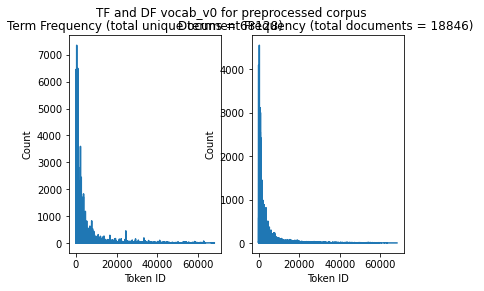

In [34]:
# plot TF and DF for vocab_v0

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = (16,6)
fig.suptitle(f'TF and DF vocab_v0 for preprocessed corpus')
ax1.plot([v for v in vocab_v0.cfs.values()])
ax2.plot([v for v in vocab_v0.dfs.values()])
ax1.set_title(f'Term Frequency (total unique terms = {len(vocab_v0)})')
ax2.set_title(f'Document Frequency (total documents = {len(corpus)}) ')
ax1.set_xlabel('Token ID')
ax1.set_ylabel('Count')
ax2.set_xlabel('Token ID')
ax2.set_ylabel('Count')

### filtering the dictionary ; only want tokens with frequency >1

In [35]:
low_tf_tokens = [w for w in vocab_v0.cfs if vocab_v0.cfs[w]<=1] # list of tokenids
#remove_ids = [vocab_v0[w] for w in low_tf_tokens] # this gives list of tokens 
print("# of ids to remove: ", len(low_tf_tokens))

vocab_v1 = deepcopy(vocab_v0)

print(f"before: {len(vocab_v1)}")
vocab_v1.filter_tokens(bad_ids=low_tf_tokens) #remove these tokenids
print(f"after removing low tf tokens: {len(vocab_v1)}")
vocab_v0.compactify()  # remove gaps in id sequence after words that were removed
print(f"after compactifying: {len(vocab_v1)}")

# Let's check if the new dictionary still has token with a tf <= 1
print(f"remaining tokens with tf<=1: {len([w for w in vocab_v1.cfs if vocab_v1.cfs[w]<=1])}")

# Don't forget to save your vocab ?  
#vocab_v1.save('vocab_v1.txt') 

# of ids to remove:  33416
before: 68128
after removing low tf tokens: 34712
after compactifying: 34712
remaining tokens with tf<=1: 0


Text(0, 0.5, 'Count')

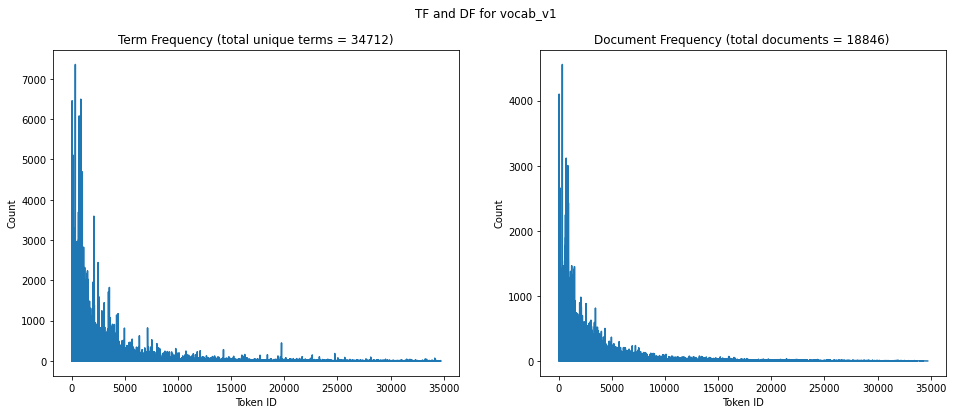

In [36]:
# plot TF and DF for vocab_v1

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = (16,6)
fig.suptitle('TF and DF for vocab_v1')
ax1.plot([v for v in vocab_v1.cfs.values()])
ax2.plot([v for v in vocab_v1.dfs.values()])
ax1.set_title(f'Term Frequency (total unique terms = {len(vocab_v1)})')
ax2.set_title(f'Document Frequency (total documents = {len(corpus)}) ')
ax1.set_xlabel('Token ID')
ax1.set_ylabel('Count')
ax2.set_xlabel('Token ID')
ax2.set_ylabel('Count')

In [37]:
# ways to filter the dictionary 

# both are based on dictionary = corpora.Dictionary(pp_corpus) 


# Prune the dict by filtering with document freq (DF)
dict1 = deepcopy(vocab_v1)
dict1.filter_extremes(no_below=5, no_above=0.5)# no_below and no_above are related to DF
print(dict1)

vocab_v2 = deepcopy(vocab_v1)
vocab_v2.filter_extremes(no_below=5, no_above=0.5, keep_n=2000)
print(vocab_v2)

Dictionary(14709 unique tokens: ['cub', 'era', 'good', 'guzman', 'higher']...)
Dictionary(2000 unique tokens: ['good', 'higher', 'idiot', 'pitch', 'pitcher']...)


In [38]:
d1 = corpora.Dictionary(pp_corpus) 
#why making another corpora.Dictionary dict?
#just to compare the filtering? 

print(f"preprocessed Corpora statistics")
print("Number of docs: ", len(pp_corpus))
print("Number of unique words: ", len(d1))
print("Number of words with frequency>1: ", d1.filter_extremes(no_below=5, no_above=0.5))
print(d1)
print(vocab_v1)

preprocessed Corpora statistics
Number of docs:  18846
Number of unique words:  68128
Number of words with frequency>1:  None
Dictionary(14709 unique tokens: ['cub', 'era', 'good', 'guzman', 'higher']...)
Dictionary(34712 unique tokens: ['castillo', 'cub', 'era', 'good', 'guzman']...)


## 2. BoW and TF-IDF model

### Bag-of-Words

In [39]:
# vocab_v1 = corpora.Dictionary(pp_corpus) 

# pass the tokenised sentences to vocab_v1.doc2bow() model
BoW_corpus = [vocab_v1.doc2bow(doc, allow_update=False) for doc in pp_corpus] 
# BoW output (0,1) means the word with id=0 appears once in the current document

len(vocab_v1) #allow_update=True will include new words in pp_corpus aka those already filtered

34712

In [40]:
pprint(BoW_corpus[:10])

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1)],
 [(10, 1),
  (17, 1),
  (18, 1),
  (19, 2),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 2),
  (28, 2),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 2),
  (37, 3),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 2),
  (45, 1),
  (46, 2),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 2),
  (59, 1),
  (60, 1),
  (61, 3),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 3),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 2),
  (74, 1),
  (75, 1),
  (76, 2),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1)],
 [(3, 2

In [41]:
id_words = [[(vocab_v1[id], count) for id, count in doc] for doc in BoW_corpus[:10]]
id_words

[[('castillo', 1),
  ('cub', 1),
  ('era', 1),
  ('good', 1),
  ('guzman', 1),
  ('harkei', 1),
  ('hibbard', 1),
  ('higher', 1),
  ('idiot', 1),
  ('morgan', 1),
  ('pitch', 1),
  ('pitcher', 1),
  ('run', 1),
  ('stud', 1),
  ('think', 1),
  ('won', 1),
  ('year', 1)],
 [('pitch', 1),
  ('alright', 1),
  ('annoi', 1),
  ('appl', 2),
  ('appolog', 1),
  ('aw', 1),
  ('backlog', 1),
  ('big', 1),
  ('boot', 1),
  ('button', 1),
  ('cabl', 1),
  ('centri', 2),
  ('come', 2),
  ('complain', 1),
  ('connect', 1),
  ('control', 1),
  ('conveni', 1),
  ('deal', 1),
  ('dealer', 1),
  ('decid', 1),
  ('drive', 2),
  ('ethernet', 3),
  ('except', 1),
  ('exchang', 1),
  ('fast', 1),
  ('featur', 1),
  ('function', 1),
  ('got', 1),
  ('great', 2),
  ('happi', 1),
  ('hard', 2),
  ('have', 1),
  ('heard', 1),
  ('high', 1),
  ('interupt', 1),
  ('keyboard', 1),
  ('know', 1),
  ('lack', 1),
  ('literatur', 1),
  ('locat', 1),
  ('loos', 1),
  ('machin', 1),
  ('mention', 2),
  ('nosi', 1),
  

### TF-IDF model
the vectors will be converted from old representation to new representation. As we have initialised the tfidf model in above step, the tfidf will now be treated as a read only object. Here, by using this tfidf object we will convert our vector from bag of word representation (old representation) to Tfidf real-valued weights (new representation).

Tf-Idf expects a bag-of-words (integer values) training corpus during initialization. During transformation, it will take a vector and return another vector of the same dimensionality, except that features which were rare in the training corpus will have their value increased. It therefore converts integer-valued vectors into real-valued ones, while leaving the number of dimensions intact. It can also optionally normalize the resulting vectors to (Euclidean) unit length.

In [42]:
tfidf_model = models.TfidfModel(corpus=BoW_corpus,
                               dictionary=vocab_v1)  # step 1 - initialize a model

tfidf_vectors = [tfidf_model[doc] for doc in BoW_corpus] # step 2 - transform vectors

tfidf_vectors[:10]

[[(0, 0.3673426722870045),
  (1, 0.24293425436849128),
  (2, 0.22942649053490272),
  (3, 0.08341140388049796),
  (4, 0.32614402622191063),
  (5, 0.3843737849188925),
  (6, 0.3552589055704016),
  (7, 0.1687739846611702),
  (8, 0.21529334702932038),
  (9, 0.2766359289888508),
  (10, 0.18888933675589725),
  (11, 0.20652483236248992),
  (12, 0.10189619776625021),
  (13, 0.30911291359002263),
  (14, 0.07177242921873148),
  (15, 0.13234301943528273),
  (16, 0.08849698748998466)],
 [(10, 0.09468056625679659),
  (17, 0.14034869775120046),
  (18, 0.10829491540390164),
  (19, 0.16845676762950307),
  (20, 0.17337496998747592),
  (21, 0.11094291481291013),
  (22, 0.17807312432169525),
  (23, 0.06644140706964546),
  (24, 0.09900606655564878),
  (25, 0.09988608016169793),
  (26, 0.0904282388532137),
  (27, 0.23106564009653302),
  (28, 0.09454081945979699),
  (29, 0.10176478844254329),
  (30, 0.07518904230400197),
  (31, 0.060318985305541244),
  (32, 0.10717671971991788),
  (33, 0.07158338624592997),

## 3.  LDA Model - topic modeling
Train a LDA model with Vocab v1. Visualize topics with at least two different methods, and get the topic distribution (as features) for each document.
https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [44]:
lda_model_v1 = models.LdaModel(
    corpus=BoW_corpus, # list of docs each represented as a list of tuples (word ID, word freq)
    num_topics=num_topics, # 20 given topics
    id2word=vocab_v1, # list of docs -> each doc is list of tokens 
#     random_state=100, 
#     update_every=1, 
#     chunksize=100, 
#     passes=10, 
#     alpha='auto', # a priori
#     per_word_topics=True
)

lda_model_v1.log_perplexity(BoW_corpus)

-9.540981464246478

### 3.1a Visualize topics - Word cloud

In [45]:
lda_learned_topics = lda_model_v1.show_topics(
    num_topics=len(dataset.target_names),
    formatted=False
)

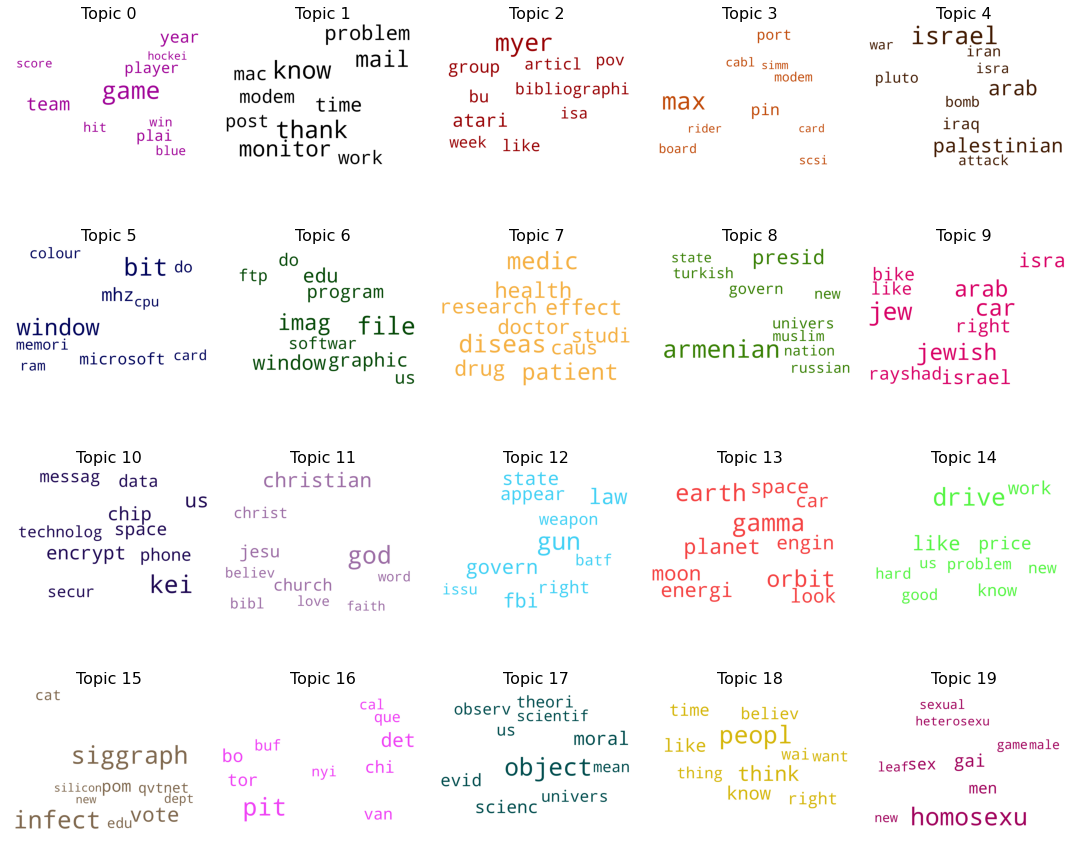

In [46]:
from wordcloud import WordCloud
#cols = [color for name, color in mcolors.XKCD_COLORS.items()]

# list of colors for 20 topics
cols = ['#a00498', '#000000', '#980002', '#c14a09', '#411900', '#00035b', '#054907', 
        '#f5b042', '#388004', '#d90166', '#1f0954', '#9c6da5', '#42d1f5', 
        '#f54242', '#54f542', '#7f684e', '#ef42f5', '#014d4e', '#d5b60a', '#a0025c']

cloud = WordCloud(stopwords=None,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(4, 5, figsize=(15,13), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(lda_learned_topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### 3.1b Visualize topics - Intertopic Distance Map

In [47]:
import warnings
warnings.filterwarnings('ignore')
import pyLDAvis
import pyLDAvis.gensim_models as gensim_vis
pyLDAvis.enable_notebook()
vis = gensim_vis.prepare(lda_model_v1, BoW_corpus, dictionary=vocab_v1)
vis

/Users/brendawang/.local/share/virtualenvs/COEN-240-machine-learning-0tZEDe65/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/brendawang/.local/share/virtualenvs/COEN-240-machine-learning-0tZEDe65/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/brendawang/.local/share/virtualenvs/COEN-240-machine-learning-0tZEDe65/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/brendawang/.local/share/virtua

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.081740  0.087653       1        1  20.227270
6      0.209187 -0.003414       2        1  13.804888
14     0.089854 -0.039914       3        1   9.664157
8     -0.063782  0.135231       4        1   7.191605
11    -0.106573  0.058658       5        1   6.271102
10     0.108691  0.083125       6        1   6.059749
0     -0.131336 -0.137069       7        1   5.211829
12    -0.024843  0.118001       8        1   5.194722
1      0.094772 -0.060933       9        1   4.140709
17     0.037592  0.113187      10        1   3.729812
7      0.017768  0.146013      11        1   3.204405
13     0.031192 -0.005740      12        1   3.015787
9     -0.083893 -0.023431      13        1   2.425381
3      0.118062 -0.176653      14        1   1.964755
19    -0.196418 -0.138682      15        1   1.774066
5      0.150743 -0.117958      16        1   1.675982
16    -0.134245 -0.089027      17        1   1.320299
2      0.000500  0.012380      18        1   1.198081
4     -0.040626  0.030206      19        1   1.078995
15     0.005095  0.008367      20        1   0.846404, topic_info=        Term         Freq        Total Category  logprob  loglift
776   window  3497.000000  3497.000000  Default  30.0000  30.0000
2047     god  3948.000000  3948.000000  Default  29.0000  29.0000
1037     max  1875.000000  1875.000000  Default  28.0000  28.0000
910     game  3067.000000  3067.000000  Default  27.0000  27.0000
718      bit  2865.000000  2865.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
428      new    58.908128  5229.386480  Topic20  -5.3795   0.2859
1045     mil    36.671790   226.425510  Topic20  -5.8534   2.9515
380     like    48.124459  8004.180084  Topic20  -5.5816  -0.3420
700       us    43.795626  6367.145290  Topic20  -5.6759  -0.2074
177      com    38.666722  2157.005954  Topic20  -5.8005   0.7504

[1470 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
8887      1  0.097648      aaron
8887      7  0.061030      aaron
8887      9  0.817805      aaron
8887     12  0.012206      aaron
9706      1  0.979382    abraham
...     ...       ...        ...
89       20  0.002398  yesterdai
9979      1  0.030949    zionism
9979     13  0.959411    zionism
8051      1  0.063033    zionist
8051     13  0.924486    zionist

[8333 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 7, 15, 9, 12, 11, 1, 13, 2, 18, 8, 14, 10, 4, 20, 6, 17, 3, 5, 16])

### 3.1c visualize topics - bar graph

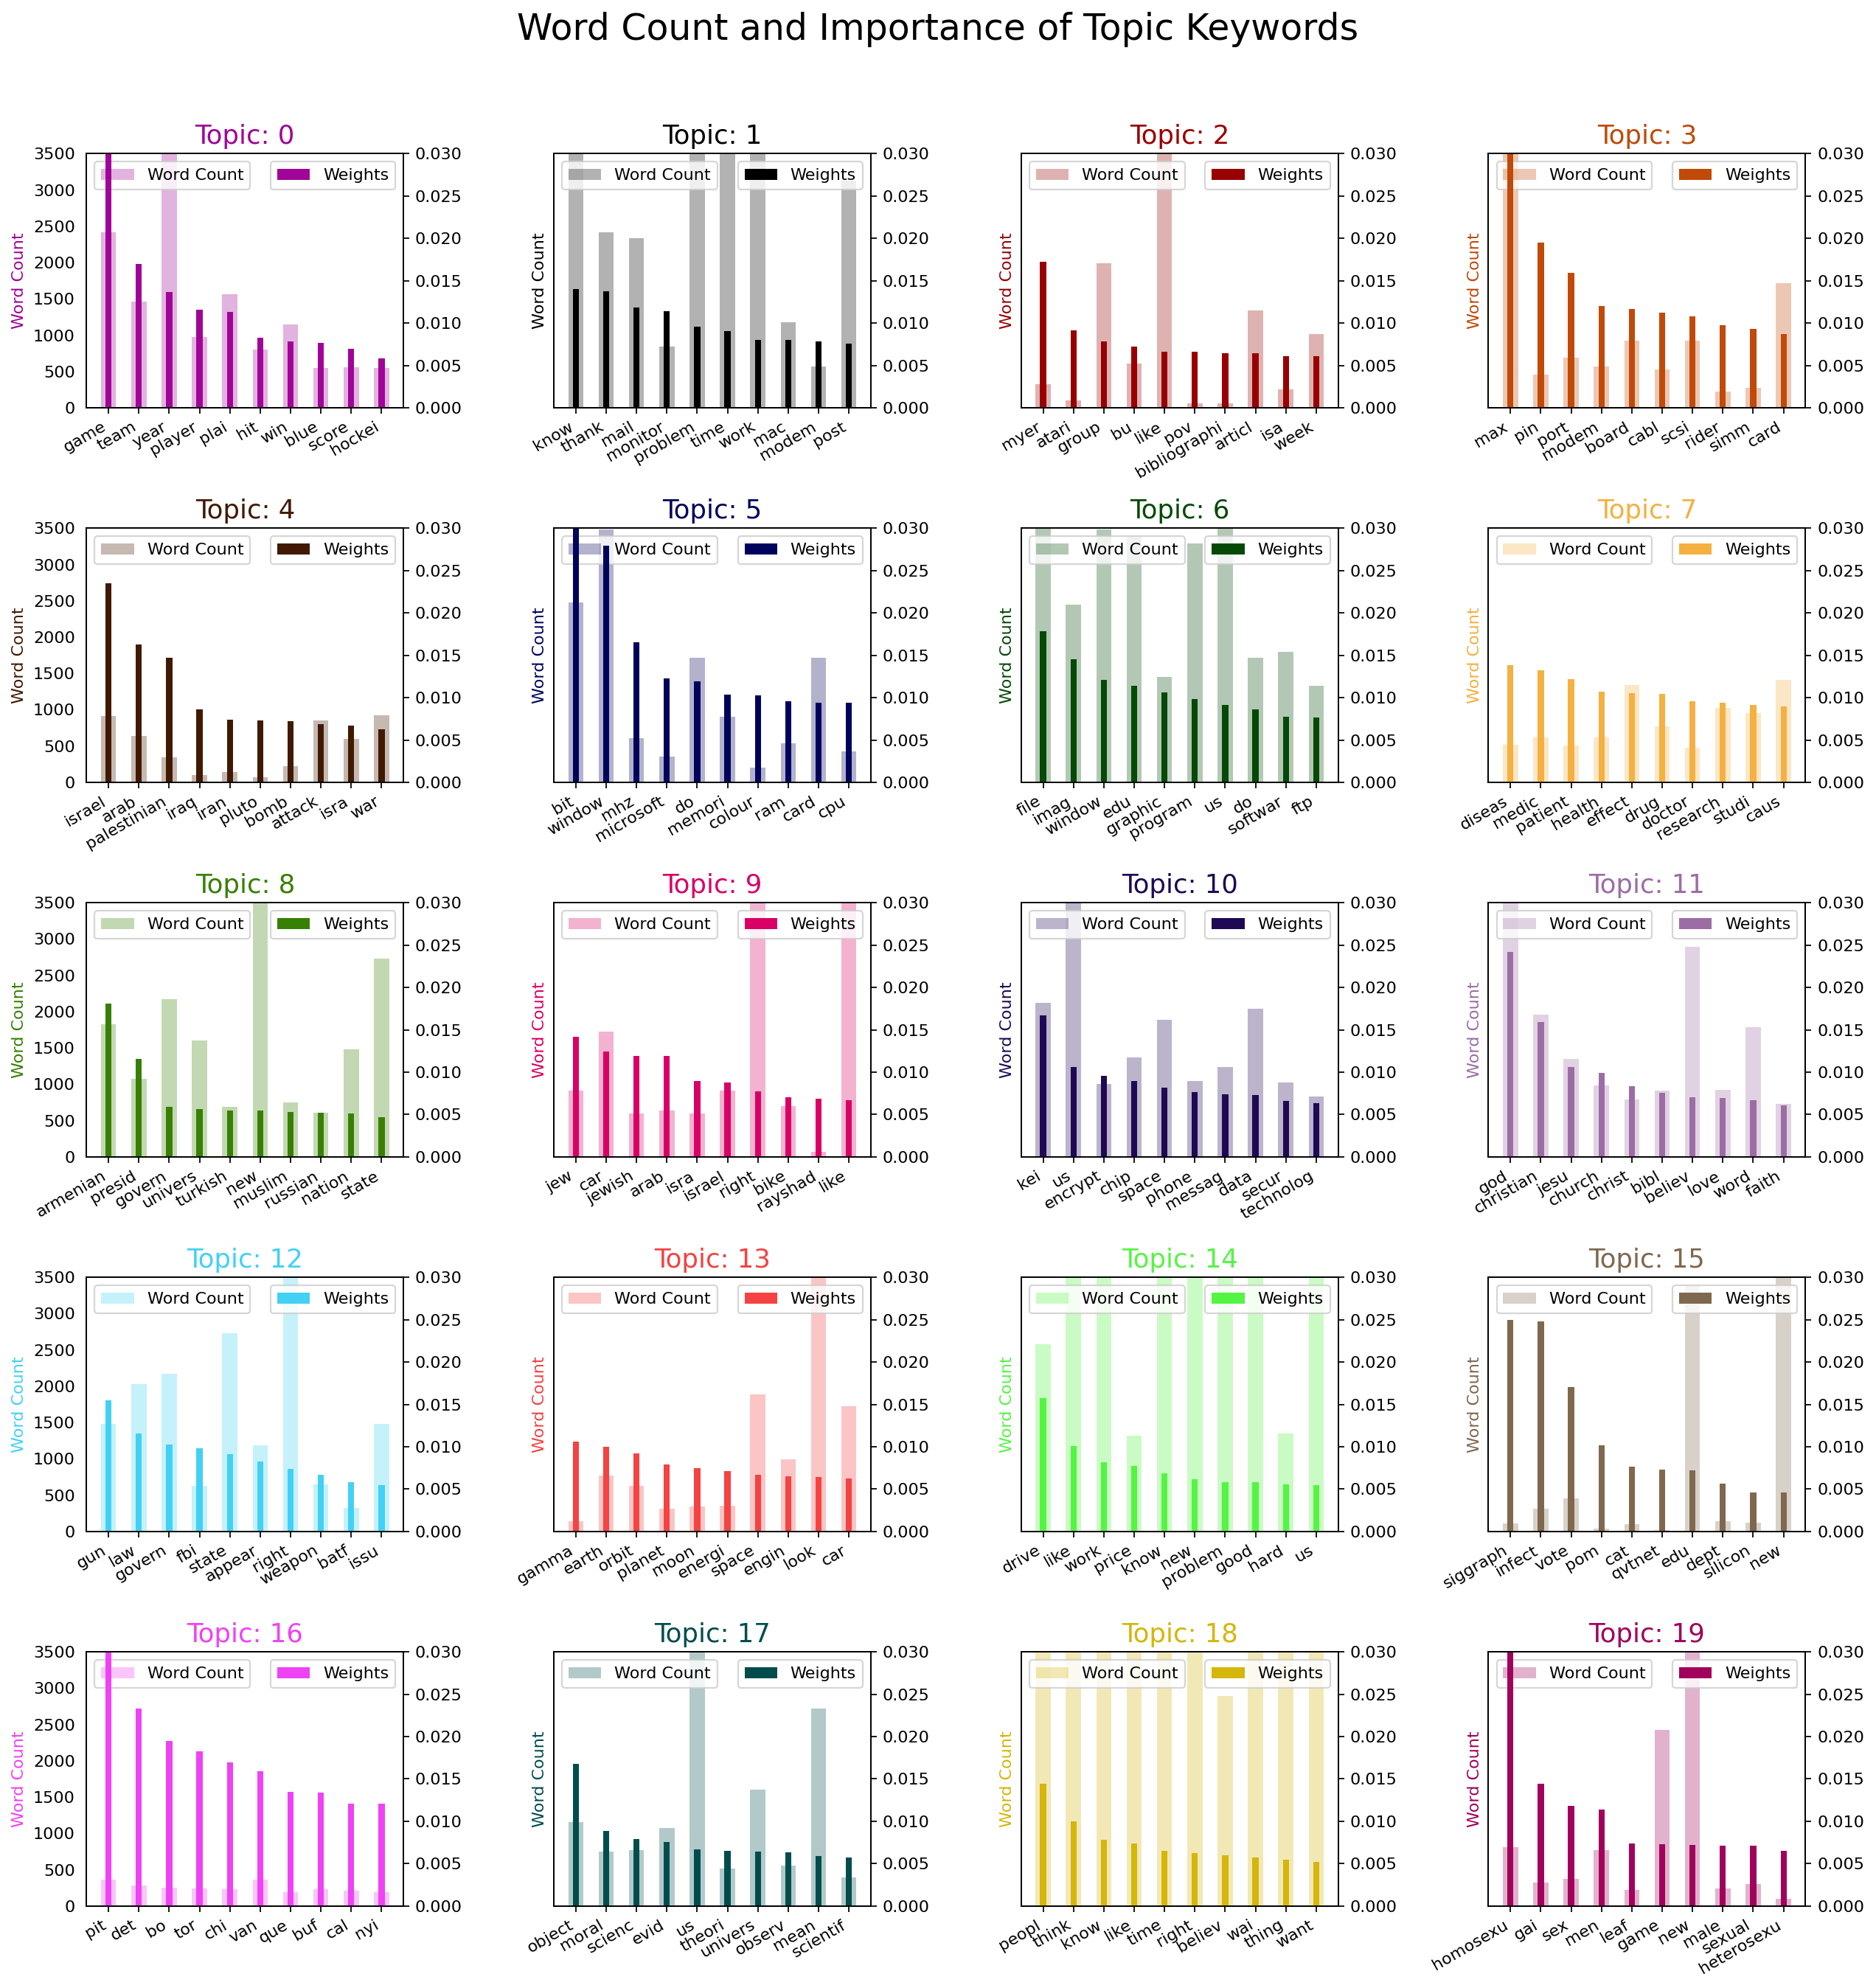

In [48]:
import pandas as pd
from collections import Counter
topics = lda_model_v1.show_topics(num_topics=num_topics, formatted=False)
data_flat = [w for w_list in pp_corpus for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 4, figsize=(16,16), sharey=True, dpi=160)
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### 3.2 Topic distribution (as features) for each document

In [49]:
# input = lda model (trained v1 or v2); doc in a BoW
# output = a list of 20 probabilities for the 20 topics that the model predicts the doc belongs to

def get_topic_dist(lda_model, doc):
    
    topics = lda_model.get_document_topics(bow=doc, minimum_probability=0) # returns list of tuples 
    
    return [ prob for _,prob in topics ]

In [50]:
doc_topic_dist_v1 = [get_topic_dist(lda_model_v1, doc) for doc in BoW_corpus] # list of lists
print(np.shape(doc_topic_dist_v1))
doc_topic_dist_v1[:10]

(18846, 20)


[[0.44164923,
  0.0027836743,
  0.0027836743,
  0.0027836743,
  0.0027836743,
  0.0027836743,
  0.0027836743,
  0.0027836743,
  0.0027836743,
  0.0027836743,
  0.0027836743,
  0.0027836743,
  0.0027836743,
  0.0027836743,
  0.0027836743,
  0.5082446,
  0.0027836743,
  0.0027836743,
  0.0027836743,
  0.0027836743],
 [0.0005594589,
  0.18322495,
  0.00055945886,
  0.06852981,
  0.00055945886,
  0.00055945886,
  0.00055945886,
  0.00055945886,
  0.00055945886,
  0.00055945886,
  0.13783929,
  0.02773174,
  0.00055945886,
  0.00055945886,
  0.57428235,
  0.00055945886,
  0.00055945886,
  0.00055945886,
  0.00055945886,
  0.00055945886],
 [0.014807912,
  4.8543065e-05,
  0.0068902513,
  0.006103921,
  0.00515825,
  4.8543065e-05,
  0.16507004,
  4.8543065e-05,
  0.1498955,
  0.0014053404,
  0.4895544,
  0.0055145486,
  0.0043333797,
  4.8543065e-05,
  0.010234874,
  5.3689953e-05,
  0.034317363,
  0.08679972,
  4.8543065e-05,
  0.01961807],
 [0.0005244017,
  0.0005244017,
  0.0005244017,
  

In [51]:
# actually want to keep all 20 topic probabilities for (reduction and then) k-means

# get best topic prediction for each doc
# lda_pred_topic = list()

# for doc in doc_topic_dist:
#     # pick tuple with topic for highest probability 
#     best_tuple = max(doc, key=lambda x:x[1])
#     lda_pred_topic.append(best_tuple[0])
    
# lda_pred_topic[:10]

## 4. Word2Vec and Doc2Vec
Train Word2Vec and Doc2Vec models upon Vocab v1. Visualize your learned word and document embedding space (e.g., using t-SNE). Collect Doc2Vec representation of each document.

### 4.1 Word2Vec 
Using large amounts of unannotated plain text, word2vec learns relationships between words automatically. 
It embeds words in a lower-dimensional vector space using a shallow neural network. The result is a set of word-vectors where vectors close together in vector space have similar meanings based on context, and word-vectors distant to each other have differing meanings.

In [52]:
w2v_model = models.Word2Vec(sentences=pp_corpus, min_count=10) #default min_count=5, default vector_size=100
print(w2v_model)
w2v_vectors = w2v_model.wv.vectors #output are vectors, one vector per word -> improvement over traditional BoW

Word2Vec(vocab=11325, vector_size=100, alpha=0.025)


In [53]:
print(np.shape(w2v_vectors))
w2v_vectors[0] #length of each vector is 100

(11325, 100)


array([-2.54591256e-01,  1.27390158e+00,  1.03479218e+00,  9.39474583e-01,
       -4.61615235e-01, -5.95772684e-01, -6.06298804e-01,  9.72022295e-01,
       -3.60954285e-01, -1.13662682e-01,  2.42775381e-01, -5.54449409e-02,
       -7.49430776e-01,  2.65041023e-01, -1.99502036e-01, -1.13903725e+00,
       -1.17718406e-01, -8.47572163e-02, -1.45667624e+00,  1.27972728e-02,
        6.70324624e-01,  4.22049403e-01,  7.61430860e-01,  1.75861754e-02,
        1.34446979e-01, -1.41667768e-01, -2.84467161e-01, -4.68841255e-01,
       -7.44214177e-01,  3.53794485e-01, -8.06068122e-01, -5.55437580e-02,
        1.04089475e+00, -4.36979473e-01,  4.40274552e-02, -6.00069940e-01,
        8.63233984e-01, -6.65356457e-01,  7.36895800e-01, -1.06483936e+00,
       -1.95569301e+00, -5.95898688e-01, -9.90238845e-01,  3.84100795e-01,
       -1.73151046e-01, -2.65352190e-01, -4.09296870e-01,  8.18685353e-01,
        6.88217819e-01,  1.26338625e+00, -2.10718662e-02,  4.28491861e-01,
       -3.44262546e-04, -

In [54]:
w2v_model.corpus_count

18846

#### 4.1a Visualize Word2Vec embeddings with t-SNE
https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

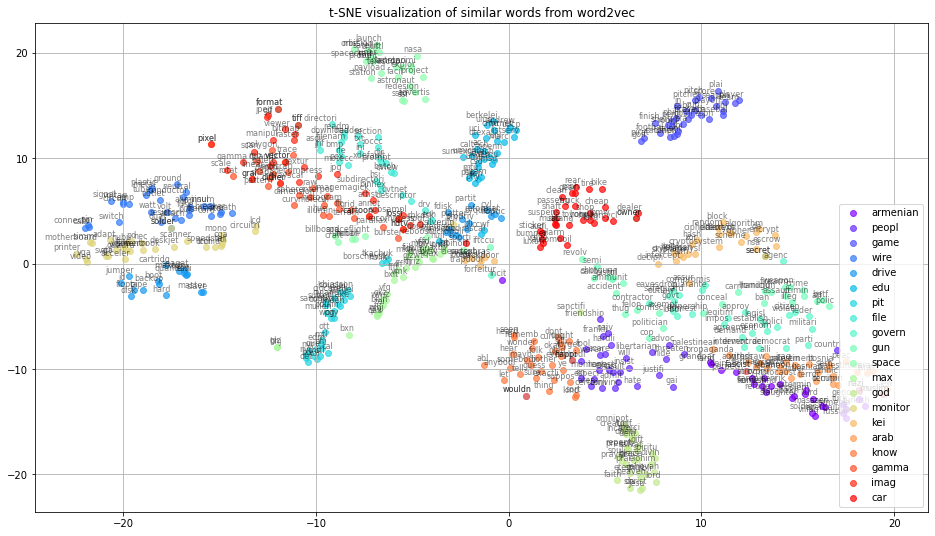

In [55]:
def train_word2vec(filename):
    data = word2vec.LineSentence(filename)
    return Word2Vec(data, size=200, window=5, min_count=5,)

# idk just picked word with high probability per topic from LDA result
keys = ['armenian', 'peopl', 'game', 'wire', 'drive', 'edu', 'pit', 'file', 'govern',
        'gun', 'space', 'max', 'god', 'monitor', 'kei', 'arab', 'know', 'gamma', 'imag', 'car']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
    


embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=50, n_components=2, learning_rate=150, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

import matplotlib.cm as cm

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('t-SNE visualization of similar words from word2vec', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

### 4.2 Doc2Vec 
used to create a vectorised representation of a group of words taken collectively as a single unit. It doesn’t only give the simple average of the words in the sentence.



In [ ]:
from os.path import exists

model_filename = 'd2v.model'

if exists(model_filename):
    print(f'Loading Doc2Vec model from {model_filename}')
    d2v_model = doc2vec.Doc2Vec.load(model_filename)
    print(f'Loaded Doc2Vec model from {model_filename}')
else: 
    print('Model file not found')
    print('Training Doc2Vec model from scratch')
    
    # https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5
    
    tagged_documents = [doc2vec.TaggedDocument(pp_doc, [i]) for i, pp_doc in enumerate(pp_corpus)]
    
    d2v_model = doc2vec.Doc2Vec( 
        vector_size=20, 
        alpha=0.025,
        min_count=2, 
        epochs=40,
        dm=1
        # dm defines the training algorithm. If dm=1 means ‘distributed memory’ (PV-DM) and dm =0 means ‘distributed bag of words’ (PV-DBOW). 
        # Distributed Memory model preserves the word order in a document 
        # whereas Distributed Bag of words just uses the bag of words approach, which doesn’t preserve any word order.
    ) 


    d2v_model.build_vocab(tagged_documents)

    max_epochs = 10
    for epoch in range(max_epochs):
        print(f'iteration {epoch + 1}')
        d2v_model.train(tagged_documents,
                        total_examples=d2v_model.corpus_count,
                        epochs=d2v_model.epochs)


        d2v_model.alpha -= 0.0002 # decrease the learning rate

        d2v_model.min_alpha = d2v_model.alpha # fix the learning rate, no decay

    print('Saving model to disk')
    d2v_model.save(model_filename)
    print(f'Model saved to {model_filename}')

In [ ]:
tagged_documents = [doc2vec.TaggedDocument(pp_doc, [i]) for i, pp_doc in enumerate(pp_corpus)]
print(tagged_documents[:1])

d2v_model = doc2vec.Doc2Vec(vector_size=40, min_count=2, epochs=30)
d2v_model.build_vocab(tagged_documents)

d2v_model.train(tagged_documents, 
                total_examples=d2v_model.corpus_count, 
                epochs=d2v_model.epochs)

In [ ]:
# don't use this one ? 

# d2v_vectors = list()
# for i in range(d2v_model.corpus_count):
#     d2v_vectors.append(d2v_model[i].tolist())

d2v_vectors = [d2v_model[i].tolist() for i in range(d2v_model.corpus_count)]
    
print(np.shape(d2v_vectors))
d2v_vectors[:10]

#### 4.2a Collect Doc2Vec representation of each document

In [ ]:
d2v_docvectors = [d2v_model.dv[i] for i in range(len(corpus))]

print(np.shape(d2v_docvectors))

d2v_docvectors[:10]

#### 4.2b Visualize learned document embedding space (e.g., using t-SNE)

In [ ]:
# Instantiate TSNE model with Sk-learn implmentation
tsne = TSNE(n_components=2, init='pca') #reduce to 2 dimensions

X_tsne = tsne.fit_transform(d2v_docvectors)

In [ ]:
np.shape(X_tsne)

In [ ]:
gnd_labels

In [ ]:
plt.figure()
fig.suptitle('Doc2Vec TSNE Embeddings')

# ax1.scatter(X_tsne1[:,0], X_tsne1[:,1], label=semantic_labels[i])

for i, color, label in zip(range(20), cols, gnd_labels):
    plt.scatter(X_tsne1[i==gnd_labels, 0], X_tsne1[i==gnd_labels, 1], color=color, label=dataset.target_names[label])


# for i,color in zip(cols, range(20):
#      ax1.scatter(X_tsne1[i], X_tsne1[gnd == i, 1], alpha=.8, label=semantic_labels[i])
    

plt.legend()
plt.show()

## 5. K-means
Conduct document clustering by K-means with four different doc. representations that you obtained from Step 2-4, including i) BoW; ii) TF-IDF; iii) Topics distribution; and iv) Doc2Vec. Obtain another vocabulary, denoted as Vocab v2, by taking the top 2K words from Vocab v1. Learn the above four doc. representations (i.e., i-iv) with Vocab v2 and get the K-means clustering result by NMI for each doc. representation method. To sum up, you should have (1) a table with the size of 2 × 4 NMI values and (2) a visualization (similar to HW3) result of the best clustering result indicated by NMI.

* k-means model will cluster documents by topic (20 total)

In [ ]:
#https://scikit-learn.org/stable/modules/model_persistence.html
#from joblib import dump, load

K = num_topics #20

clustering_labels = [f'Cluster {i}'for i in range(20)]

plt.rcParams["figure.figsize"] = (16,6)

# import seaborn as sns
# sns.set

In [ ]:
# actually this does not actually produce a dense vector? it just makes the corpus doc lengths equal sized by throwing in a bunch of zeros
# so that kmeans will take it

# https://machinelearningmastery.com/sparse-matrices-for-machine-learning/

# input: data is BoW/model vector; vocab_list is gensim.corpora.Dictionary 
# output: dense vector -> no. docs x no. words

def sparse_to_dense(data, vocab_dict):
    
    dense_data = list() 
    
    for doc in data:
        doc_dense_vector = [0] * len(vocab_dict) # doc_dense_vector initialized to 0 counts for every word 
        
        for word_tuple in doc:
            doc_dense_vector[word_tuple[0]] = word_tuple[1]  # update count of index for each word that actually appears in the doc
            
        dense_data.append(doc_dense_vector)
        
    return dense_data
        

### 5.1 K-means for vocab_v1

#### 5.1.1 K-means on BoW for vocab_v1

In [ ]:
# bag of words 

# turn vocab_v1's BoW into dense vector

v1_dense_BoW = sparse_to_dense(BoW_corpus, vocab_v1) # index = tokenid, value at each index = token frequency for current doc 

np.shape(v1_dense_BoW) # should be no. docs x no. tokens

In [ ]:
len(gnd_labels) == len(v1_dense_BoW)

##### 5.1.1.a unreduced 

In [ ]:
# BoW 

km = KMeans(n_clusters=20, init='random', n_init=1)
idx, nmis = [], []

for i in range(10):
    # run K-means here
    km_run = km.fit(v1_dense_BoW)
    
    # idx.append(the obtained clustering labels)
    idx.append(km_run.labels_)
    
    # nmi.append(nmi_score(gnd, clustering label))
    nmis.append(nmi_score(gnd_labels, km_run.labels_)) # size of gnd_labels must match dense vector BoW input


nmi_bow_v1 = np.mean(nmis)


# report mean and std values of nmis    
print("v1_dense_BoW no reduction: ")
print(f"Kmeans mean of nmis: {np.mean(nmis)}" )
print(f"Kmeans std of nmis: {np.std(nmis)}")

# Kmeans mean of nmis:  0.04343612891864067
# Kmeans std of nmis:  0.008858348193992314

##### 5.1.1.b reduced w/ PCA

In [ ]:
# reduce dimensionality BoW v1 w/ PCA

pca = PCA(n_components=2)
pca_BoW_v1 = pca.fit_transform(v1_dense_BoW)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
# >> Explained variation per principal component: [0.23309307 0.09213758]

print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca.explained_variance_ratio_)))
# >> Cumulative variance explained by 2 principal components: 32.52%

np.shape(pca_BoW_v1) # total docs x 2 dimensions 

In [ ]:
# kmeans w/ pca reduced BoW v1

km = KMeans(n_clusters=20, init='random', n_init=1)
idx, nmis = [], []

for i in range(20):
    # run K-means here
    km_run = km.fit(pca_BoW_v1)
    
    # idx.append(the obtained clustering labels)
    idx.append(km_run.labels_)
    
    # nmi.append(nmi_score(gnd, clustering label))
    nmis.append(nmi_score(gnd_labels, km_run.labels_)) # size of gnd_labels must match dense vector BoW input

nmi_bow_v1_reduced = max(nmis)
best_idx = nmis.index(nmi_bow_v1_reduced)

# report mean and std values of nmis    
print("v1_dense_BoW reduced by PCA: ")
print(f"Kmeans mean of nmis: {np.mean(nmis)}" )
print(f"Kmeans std of nmis: {np.std(nmis)}")

# v1_dense_BoW reduced by PCA: 
# Kmeans mean of nmis: 0.023207941387739496
# Kmeans std of nmis: 0.0006189383315435271

In [ ]:
#plt.scatter(pca_BoW_v1[:,0], pca_BoW_v1[:,1])

fig, (ax1) = plt.subplots(1, 1)
ax1.set_xlim([-0.3, -0.2])
ax1.set_ylim([-5,10])

for color, i in zip(cols, range(20)):
    if i==5: continue
    ax1.scatter(pca_BoW_v1[idx[best_idx]==i,0], pca_BoW_v1[idx[best_idx]==i,1], color=color, label=clustering_labels[i])

ax1.legend(fancybox=True, framealpha=0.5)


In [ ]:
max(pca_BoW_v1[1])

#### 5.1.2 K-means on TF-IDF for vocab_v1

In [ ]:
# tf-idf

# turn vocab_v1's tfidf vectors into dense vector

v1_dense_tfidf = sparse_to_dense(tfidf_vectors, vocab_v1)
np.shape(v1_dense_BoW) # should be no. docs x no. tokens

##### 5.1.2.a unreduced

In [ ]:
# tf-idf

km = KMeans(n_clusters=20, init='random', n_init=1)
idx, nmis = [], []

for i in range(10):
    # run K-means here
    km_run = km.fit(v1_dense_tfidf)
    
    # idx.append(the obtained clustering labels)
    idx.append(km_run.labels_)
    
    # nmi.append(nmi_score(gnd, clustering label))
    nmis.append(nmi_score(gnd_labels, km_run.labels_)) # size of gnd_labels must match dense vector BoW input
    

nmi_tfidf_v1 = np.mean(nmis)

# report mean and std values of nmis    
print("v1_dense_tfidf unreduced: ")
print(f"Kmeans mean of nmis: {np.mean(nmis)}" )
print(f"Kmeans std of nmis: {np.std(nmis)}")

# Kmeans mean of nmis:  0.17898630119093667
# Kmeans std of nmis:  0.14276668507023932

##### 5.1.2.b reduced

In [ ]:
# reduce dimensionality of tfidf v1 w/ PCA

pca = PCA(n_components=2)
pca_tfidf_v1 = pca.fit_transform(v1_dense_tfidf)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
# >> Explained variation per principal component: [0.00452119 0.00333329]

print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca.explained_variance_ratio_)))
# >> Cumulative variance explained by 2 principal components: 0.79%

np.shape(pca_tfidf_v1) # total docs x 2 dimensions 

In [ ]:
# kmeans w/ pca reduced tfidf v1

km = KMeans(n_clusters=20, init='random', n_init=1)
idx, nmis = [], []

for i in range(20):
    # run K-means here
    km_run = km.fit(pca_tfidf_v1)
    
    # idx.append(the obtained clustering labels)
    idx.append(km_run.labels_)
    
    # nmi.append(nmi_score(gnd, clustering label))
    nmis.append(nmi_score(gnd_labels, km_run.labels_)) # size of gnd_labels must match dense vector BoW input

nmi_tfidf_v1_reduced = max(nmis)
best_idx = nmis.index(nmi_tfidf_v1_reduced)

# report mean and std values of nmis    
print("v1_dense_tfidf reduced by PCA: ")
print(f"Kmeans mean of nmis: {np.mean(nmis)}" )
print(f"Kmeans std of nmis: {np.std(nmis)}")

# v1_dense_tfidf reduced by PCA: 
# Kmeans mean of nmis: 0.2678904881670582
# Kmeans std of nmis: 0.0031759979601812395

In [ ]:
plt.scatter(pca_tfidf_v1[:,0], pca_tfidf_v1[:,1], ) 

In [ ]:
#plt.scatter(pca_tfidf_v1[:,0], pca_tfidf_v1[:,1], ) 

fig, (ax1) = plt.subplots(1, 1)
fig.suptitle('TF-IDF reduced to 2 dimensions and clustered by K-means')

for color, i in zip(cols, range(20)):
    ax1.scatter(pca_tfidf_v1[idx[best_idx]==i,0], pca_tfidf_v1[idx[best_idx]==i,1], color=color, label=clustering_labels[i])

ax1.legend(fancybox=True, framealpha=0.5)

#### 5.1.3 K-means on topic modeling / LDA for vocab_v1

In [ ]:
# reduce demensionality of doc_topic_dist_v1

pca = PCA(n_components=2)
pca_lda_v1 = pca.fit_transform(doc_topic_dist_v1)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# >> Explained variation per principal component: [0.00452119 0.00333329]
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca.explained_variance_ratio_)))

# >> Cumulative variance explained by 2 principal components: 0.79%

np.shape(pca_lda_v1) # total docs x 2 dimensions 

In [ ]:
# lda

km = KMeans(n_clusters=20, init='random', n_init=1)
idx, nmis = [], []

for i in range(10):
    # run K-means here
    km_run = km.fit(pca_lda_v1)
    
    # idx.append(the obtained clustering labels)
    idx.append(km_run.labels_)
    
    # nmi.append(nmi_score(gnd, clustering label))
    nmis.append(nmi_score(gnd_labels, km_run.labels_)) # size of gnd_labels must match dense vector BoW input
    

nmi_lda_v1_reduced = max(nmis)
best_idx = nmis.index(nmi_lda_v1_reduced)

# report mean and std values of nmis    
print("LDA's doc_topic_dist_v1 reduced by PCA: ")
print(f"Kmeans mean of nmis: {np.mean(nmis)}" )
print(f"Kmeans std of nmis: {np.std(nmis)}")

# LDA's doc_topic_representation reduced by PCA: 
# Kmeans mean of nmis: 0.2082766161435247
# Kmeans std of nmis: 0.0023832178369285664

In [ ]:
fig, (ax1) = plt.subplots(1, 1)

for color, i in zip(cols, range(20)):
    if i==5: continue
    ax1.scatter(pca_lda_v1[idx[best_idx]==i,0], pca_lda_v1[idx[best_idx]==i,1], color=color, label=clustering_labels[i])

ax1.legend(fancybox=True, framealpha=0.5)

#### 5.1.4 K-means on Doc2Vec for vocab_v1

In [ ]:
# doc2vec 

# first reduce dimensionality with PCA

pca = PCA(n_components=2)
pca_d2v_v1 = pca.fit_transform(d2v_docvectors)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
# >> Explained variation per principal component: [0.06809821 0.06461331]

print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca.explained_variance_ratio_)))
# >> Cumulative variance explained by 2 principal components: 13.27%

np.shape(d2v_docvectors) # total docs x 2 dimensions 

In [ ]:
# kmeans w/ pca reduced d2v v1

km = KMeans(n_clusters=20, init='random', n_init=1)
idx, nmis = [], []

for i in range(20):
    # run K-means here
    km_run = km.fit(d2v_docvectors)
    
    # idx.append(the obtained clustering labels)
    idx.append(km_run.labels_)
    
    # nmi.append(nmi_score(gnd, clustering label))
    nmis.append(nmi_score(gnd_labels, km_run.labels_)) # size of gnd_labels must match dense vector BoW input

nmi_d2v_v1_reduced = max(nmis)
best_idx = nmis.index(nmi_d2v_v1_reduced)

# report mean and std values of nmis    
print("doc2vec v1 vectors reduced by PCA: ")
print(f"Kmeans mean of nmis: {np.mean(nmis)}" )
print(f"Kmeans std of nmis: {np.std(nmis)}")

# doc2vec v1 vectors reduced by PCA: 
# Kmeans mean of nmis: 0.2784546624380601
# Kmeans std of nmis: 0.0014445631398436395

In [ ]:
fig, (ax1) = plt.subplots(1, 1)

for color, i in zip(cols, range(20)):
    ax1.scatter(pca_d2v_v1[idx[best_idx]==i,0], pca_d2v_v1[idx[best_idx]==i,1], color=color, label=clustering_labels[i])

ax1.legend(fancybox=True, framealpha=0.5)

### 5.2 Repeat step 5 with top 2k words of vocab_v1

#### 5.2.0 Learn BoW, TF-IDF, LDA, word2vec, doc2vec for vocab_v2

In [ ]:
# previously filtered to top 2k
# vocab_v2 = deepcopy(vocab_v1)
# vocab_v2.filter_extremes(no_below=5, no_above=0.5, keep_n=2000)
print(vocab_v2)

In [ ]:
BoW_corpus_v2 = [vocab_v2.doc2bow(doc, allow_update=False) for doc in pp_corpus] 

tfidf_model_v2 = models.TfidfModel(corpus=BoW_corpus_v2, dictionary=vocab_v2) # step 1 - initialize a model
tfidf_vectors_v2 = [tfidf_model_v2[doc] for doc in BoW_corpus_v2] # step 2 - transform vectors

In [ ]:
lda_model_v2 = models.LdaModel(
    corpus=BoW_corpus_v2, # list of docs each represented as a list of tuples (word ID, word freq)
    num_topics=num_topics, # 20 given topics
    id2word=vocab_v2, # list of docs -> each doc is list of tokens 
#     random_state=100, 
#     update_every=1, 
#     chunksize=100, 
#     passes=10, 
#     alpha='auto', # a priori
#     per_word_topics=True
)

#### 5.2.1 K-means on BoW for vocab_v2

In [ ]:
# turn vocab_v2's BoW into dense vector

v2_dense_BoW = sparse_to_dense(BoW_corpus_v2, vocab_v2)
    
np.shape(v2_dense_BoW) # should no. docs x no. tokens

##### 5.2.1.a unreduced

In [ ]:
# kmeans w/ unreduced dimensionality BoW

km = KMeans(n_clusters=20, init='random', n_init=1)
idx, nmis = [], []

for i in range(20):
    # run K-means here
    km_run = km.fit(v2_dense_BoW)
    
    # idx.append(the obtained clustering labels)
    idx.append(km_run.labels_)
    
    # nmi.append(nmi_score(gnd, clustering label))
    nmis.append(nmi_score(gnd_labels, km_run.labels_)) # size of gnd_labels must match dense vector BoW input

nmi_bow_v2 = max(nmis)

# report mean and std values of nmis          
print("v2_dense_BoW w/o dimensionality reduction: ")
print(f"Kmeans mean of nmis: {np.mean(nmis)}" )
print(f"Kmeans std of nmis: {np.std(nmis)}")

# v2_dense_BoW w/o dimensionality reduction: 
# Kmeans mean of nmis: 0.061519917804801885
# Kmeans std of nmis: 0.017124322479444357

##### 5.2.1.b reduced

In [ ]:
# first reduce dimensionality with PCA

pca = PCA(n_components=2)
pca_BoW_v2 = pca.fit_transform(v2_dense_BoW)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# >> Explained variation per principal component: [0.28672619 0.10643603]

print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca.explained_variance_ratio_)))

# >> Cumulative variance explained by 2 principal components: 39.32%

np.shape(pca_BoW_v2) # total docs x 2 dimensions 

In [ ]:
# kmeans w/ pca reduced BoW v2

km = KMeans(n_clusters=20, init='random', n_init=1)
idx, nmis = [], []

for i in range(20):
    # run K-means here
    km_run = km.fit(pca_BoW_v2)
    
    # idx.append(the obtained clustering labels)
    idx.append(km_run.labels_)
    
    # nmi.append(nmi_score(gnd, clustering label))
    nmis.append(nmi_score(gnd_labels, km_run.labels_)) # size of gnd_labels must match dense vector BoW input

nmi_bow_v2_reduced = max(nmis)
best_idx = nmis.index(nmi_bow_v2_reduced)

# report mean and std values of nmis    
print("v2_dense_BoW reduced by PCA: ")
print(f"Kmeans mean of nmis: {np.mean(nmis)}" )
print(f"Kmeans std of nmis: {np.std(nmis)}")

# v2_dense_BoW reduced by PCA: 
# Kmeans mean of nmis: 0.2784546624380601
# Kmeans std of nmis: 0.0014445631398436395

In [ ]:
plt.scatter(pca_BoW_v2[:,0], pca_BoW_v2[:,1])

In [ ]:
fig, (ax1) = plt.subplots(1, 1)

for color, i in zip(cols, range(20)):
    if i==17 or i==3: continue
    ax1.scatter(pca_BoW_v2[idx[best_idx]==i,0], pca_BoW_v2[idx[best_idx]==i,1], color=color, label=clustering_labels[i])

ax1.legend(fancybox=True, framealpha=0.5)

In [ ]:
pca_BoW_v2[:-10]

#### 5.2.2 K-means on TF-IDF for vocab_v2

In [ ]:
# tf-idf

# turn vocab_v2's tfidf vectors into dense vector

v2_dense_tfidf = sparse_to_dense(tfidf_vectors_v2, vocab_v2)
np.shape(v2_dense_tfidf) # should be no. docs x no. tokens

##### 5.2.2.a unreduced

In [ ]:
# k-means w/ unreduced dimensionality tf-idf

km = KMeans(n_clusters=20, init='random', n_init=1)
idx, nmis = [], []

for i in range(20):
    # run K-means here
    km_run = km.fit(v2_dense_tfidf)
    
    # idx.append(the obtained clustering labels)
    idx.append(km_run.labels_)
    
    # nmi.append(nmi_score(gnd, clustering label))
    nmis.append(nmi_score(gnd_labels, km_run.labels_)) # size of gnd_labels must match dense vector BoW input
    

nmi_tfidf_v2 = np.mean(nmis)
    
# report mean and std values of nmis          
print("v2_dense_tfidf w/o dimensionality reduction: ")
print(f"Kmeans mean of nmis: {np.mean(nmis)}" )
print(f"Kmeans std of nmis: {np.std(nmis)}")

# v2_dense_tfidf w/o dimensionality reduction: 
# Kmeans mean of nmis: 0.30030095570794085
# Kmeans std of nmis: 0.06454612818758451

##### 5.2.2.b reduced

In [ ]:
# first reduce dimensionality with PCA

pca = PCA(n_components=2)
pca_tfidf_v2 = pca.fit_transform(v2_dense_tfidf)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# >> Explained variation per principal component: [0.00775521 0.00565127]

print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca.explained_variance_ratio_)))

# >> Cumulative variance explained by 2 principal components: 1.34% <- this is very low and means a lot of data has been lost ?

np.shape(pca_BoW_v2) # total docs x 2 dimensions 

In [ ]:
# kmeans w/ pca reduced tf-idf

km = KMeans(n_clusters=20, init='random', n_init=1)
idx, nmis = [], []

for i in range(20):
    # run K-means here
    km_run = km.fit(pca_tfidf_v2)
    
    # idx.append(the obtained clustering labels)
    idx.append(km_run.labels_)
    
    # nmi.append(nmi_score(gnd, clustering label))
    nmis.append(nmi_score(gnd_labels, km_run.labels_)) # size of gnd_labels must match dense vector BoW input

nmi_tfidf_v2_reduced = max(nmis)
best_idx = nmis.index(nmi_tfidf_v2_reduced)

# report mean and std values of nmis    
print("v2_dense_tfidf reduced by PCA: ")
print(f"Kmeans mean of nmis: {np.mean(nmis)}" )
print(f"Kmeans std of nmis: {np.std(nmis)}")

# v2_dense_tfidf reduced by PCA: 
# Kmeans mean of nmis: 0.27908570391786547
# Kmeans std of nmis: 0.001788308906988712

In [ ]:
plt.scatter(pca_tfidf_v2[:,0], pca_tfidf_v2[:,1])

In [ ]:
fig, (ax1) = plt.subplots(1, 1)
fig.suptitle('TF-IDF (top 2k frequent words) reduced to 2 dimensions and clustered by K-means')

for color, i in zip(cols, range(20)):
    ax1.scatter(pca_tfidf_v2[idx[best_idx]==i,0], pca_tfidf_v2[idx[best_idx]==i,1], color=color, label=clustering_labels[i])

ax1.legend(fancybox=True, framealpha=0.5)

#### 5.2.3 K-means on topic modeling / LDA for vocab_v2

In [ ]:
doc_topic_dist_v2 = [get_topic_dist(lda_model_v2, doc) for doc in BoW_corpus_v2] # list of lists
print(np.shape(doc_topic_dist_v2))
doc_topic_dist_v2[:10]

In [ ]:
# reduce demensionality of doc_topic_dist

pca = PCA(n_components=2)
pca_lda_v2 = pca.fit_transform(doc_topic_dist_v2)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# >> Explained variation per principal component: [0.15192304 0.13366944]

print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca.explained_variance_ratio_)))

# >> Cumulative variance explained by 2 principal components: 28.56%

np.shape(pca_lda_v2) # total docs x 2 dimensions 

In [ ]:
# lda

km = KMeans(n_clusters=20, init='random', n_init=1)
idx, nmis = [], []

for i in range(10):
    # run K-means here
    km_run = km.fit(pca_lda_v2)
    
    # idx.append(the obtained clustering labels)
    idx.append(km_run.labels_)
    
    # nmi.append(nmi_score(gnd, clustering label))
    nmis.append(nmi_score(gnd_labels, km_run.labels_)) # size of gnd_labels must match dense vector BoW input
    

nmi_lda_v2_reduced = max(nmis)
best_idx = nmis.index(nmi_lda_v2_reduced)

# report mean and std values of nmis    
print("LDA's topic_prob_dist_v2 reduced by PCA: ")
print(f"Kmeans mean of nmis: {np.mean(nmis)}" )
print(f"Kmeans std of nmis: {np.std(nmis)}")

# LDA's topic_prob_dist_v2 reduced by PCA: 
# Kmeans mean of nmis: 0.2729461594524778
# Kmeans std of nmis: 0.004043940567801067

In [ ]:
fig, (ax1) = plt.subplots(1, 1)

for color, i in zip(cols, range(20)):
    if i==5: continue
    ax1.scatter(pca_lda_v2[idx[best_idx]==i,0], pca_lda_v2[idx[best_idx]==i,1], color=color, label=clustering_labels[i])

ax1.legend(fancybox=True, framealpha=0.5)

#### [INCOMPLETE] 5.2.4 K-means on Doc2Vec for vocab_v2

### 5.3 Comparison of NMIs

In [ ]:
# create dataframe

nmi_comparison = {
    '' : ['vocab_v1', 'vocab_v1_reduced', 'vocab_v2', 'vocab_v2_reduced'],
    'BoW' : [0.04343612891864067, nmi_bow_v1_reduced , nmi_bow_v2, nmi_bow_v2_reduced],
    'TF-IDF' : [0.17898630119093667, nmi_tfidf_v1_reduced, nmi_tfidf_v2, nmi_tfidf_v2_reduced],
    'LDA ' : [None, nmi_lda_v1_reduced, None, nmi_lda_v2_reduced],
    'Doc2Vec' : [None, nmi_d2v_v1_reduced, None, None],
}


# not yet run
# nmi_d2v_v1
# nmi_d2v_v2

df = pd.DataFrame(nmi_comparison)
df.style.hide(axis='index') #? how to hide index lol 
display(df) # displaying the DataFrame

print(df.to_string(index=False))

## 6. Experiment analysis 
Do experiment analysis from one of the following aspects:  

1. Impact of different preprocessing ways (e.g., compare the K-means or LDA visualizations between different vocabs)  
2. Impact of different topic numbers  
3. Impact of different clustering methods on the clustering result

### 6.1 Document topic frequency distribution
The document frequency is evenly distributed across all topics

In [ ]:
from collections import Counter
doc_topic_freq = Counter(dataset.target)
doc_topic_freq_names = {
    dataset.target_names[topic_idx]: topic_freq for topic_idx, topic_freq in doc_topic_freq.items()
}
doc_topic_freq_names

In [ ]:
tupled_labels = [tuple(label.split('.')) for label in dataset.target_names]
labeled_doc_class_dist = {tupled_labels[idx]: freq for idx, freq in doc_class_dist.items()}
pd.DataFrame(labeled_doc_class_dist.items(), columns=['document_class', 'frequency'])

In [ ]:
class_names = dataset.target_names
class_names

In [ ]:
## import pandas as pd

labeled_docs = {
    'doc': dataset.data, 
    'class_name': [dataset.target_names[x] for x in dataset.target],
    'class_id': dataset.target,
}

corpus_df = pd.DataFrame(labeled_docs)
corpus_df.head(5)

In [ ]:
def curtail_class_name(class_names, max_granularity):
    return ['.'.join(class_name.split('.')[:max_granularity]) for class_name in class_names]

limited_class_names_dict = {'class_name': class_names}

for i in reversed(range(1,5)):
    limited_class_names = curtail_class_name(class_names, i)
    unique_limited_class_names = sorted(list(set(limited_class_names)))
    limited_class_names_dict[f'class_name_limit{i}'] = limited_class_names
    limited_class_names_dict[f'class_id_limit{i}'] = [unique_limited_class_names.index(limited_class_name) for limited_class_name in limited_class_names]

limited_class_names_df = pd.DataFrame(limited_class_names_dict)
limited_class_names_df

In [ ]:
corpus_df.join(limited_class_names_df.set_index('class_name'), 'class_name')

In [ ]:
# the max granularity of class names is 5
max([len(class_name.split('.')) for class_name in dataset.target_names])

In [ ]:
origina

In [ ]:
labeled_doc_class_dist = {dataset.target_names[idx]: freq for idx, freq in doc_class_dist.items()}

In [ ]:
target_idx_to_name = {idx: label for idx, label in enumerate(dataset.target_names)}

In [ ]:
split_labels = [tuple(label.split('.')) for label in dataset.target_names]

In [ ]:
labeled_doc_class_dist = { dataset.target_names[key]: value for key, value in doc_class_dist.items() }
labeled_doc_class_dist

In [ ]:
pd.DataFrame(labeled_doc_class_dist.items(), columns=['document_class', 'frequency'])

In [ ]:
# pd.df
# plt.plot(doc_class_distribution)
# plt.xlabel("Document Class")
# plt.ylabel("# of documents")
# plt.title("Document Class Frequency")

In [ ]:
# kmeans w/ pca reduced BoW v2

km = KMeans(n_clusters=10, init='random', n_init=1)
idx, nmis = [], []

for i in range(20):
    # run K-means here
    km_run = km.fit(pca_BoW_v2)
    
    # idx.append(the obtained clustering labels)
    idx.append(km_run.labels_)
    
    # nmi.append(nmi_score(gnd, clustering label))
    nmis.append(nmi_score(gnd_labels, km_run.labels_)) # size of gnd_labels must match dense vector BoW input

nmi_bow_v2_reduced = max(nmis)
best_idx = nmis.index(nmi_bow_v2_reduced)

# report mean and std values of nmis    
print("v2_dense_BoW reduced by PCA: ")
print(f"Kmeans mean of nmis: {np.mean(nmis)}" )
print(f"Kmeans std of nmis: {np.std(nmis)}")

# v2_dense_BoW reduced by PCA: 
# Kmeans mean of nmis: 0.2784546624380601
# Kmeans std of nmis: 0.0014445631398436395

In [ ]:
fig, (ax1) = plt.subplots(1, 1)

for color, i in zip(cols, range(10)):
    ax1.scatter(pca_BoW_v2[idx[best_idx]==i,0], pca_BoW_v2[idx[best_idx]==i,1], color=color, label=clustering_labels[i])

ax1.legend(fancybox=True, framealpha=0.5)

In [ ]:
# lda

km = KMeans(n_clusters=15, init='random', n_init=1)
idx, nmis = [], []

for i in range(20):
    # run K-means here
    km_run = km.fit(pca_lda_v2)
    
    # idx.append(the obtained clustering labels)
    idx.append(km_run.labels_)
    
    # nmi.append(nmi_score(gnd, clustering label))
    nmis.append(nmi_score(gnd_labels, km_run.labels_)) # size of gnd_labels must match dense vector BoW input
    

nmi_lda_v2_reduced = max(nmis)
best_idx = nmis.index(nmi_lda_v2_reduced)

# report mean and std values of nmis    
print("LDA's topic_prob_dist_v2 reduced by PCA: ")
print(f"Kmeans mean of nmis: {np.mean(nmis)}" )
print(f"Kmeans std of nmis: {np.std(nmis)}")

# LDA's topic_prob_dist_v2 reduced by PCA: 
# Kmeans mean of nmis: 0.2729461594524778
# Kmeans std of nmis: 0.004043940567801067

In [ ]:
fig, (ax1) = plt.subplots(1, 1)

for color, i in zip(cols, range(15)):
    if i==5: continue
    ax1.scatter(pca_lda_v2[idx[best_idx]==i,0], pca_lda_v2[idx[best_idx]==i,1], color=color, label=clustering_labels[i])

ax1.legend(fancybox=True, framealpha=0.5)

In [ ]:
# lda

km = KMeans(n_clusters=5, init='random', n_init=1)
idx, nmis = [], []

for i in range(10):
    # run K-means here
    km_run = km.fit(pca_lda_v2)
    
    # idx.append(the obtained clustering labels)
    idx.append(km_run.labels_)
    
    # nmi.append(nmi_score(gnd, clustering label))
    nmis.append(nmi_score(gnd_labels, km_run.labels_)) # size of gnd_labels must match dense vector BoW input
    

nmi_lda_v2_reduced = max(nmis)
best_idx = nmis.index(nmi_lda_v2_reduced)

# report mean and std values of nmis    
print("LDA's topic_prob_dist_v2 reduced by PCA: ")
print(f"Kmeans mean of nmis: {np.mean(nmis)}" )
print(f"Kmeans std of nmis: {np.std(nmis)}")

# LDA's topic_prob_dist_v2 reduced by PCA: 
# Kmeans mean of nmis: 0.2729461594524778
# Kmeans std of nmis: 0.004043940567801067

In [ ]:
fig, (ax1) = plt.subplots(1, 1)

for color, i in zip(cols, range(5)):
    if i==5: continue
    ax1.scatter(pca_lda_v2[idx[best_idx]==i,0], pca_lda_v2[idx[best_idx]==i,1], color=color, label=clustering_labels[i])

ax1.legend(fancybox=True, framealpha=0.5)

## 7. Supervised Task
Propose one supervised task on your own. Give the motivation, methodology, and experimental results, accordingly. For example, you could propose a classification task upon the doc. representations we learned so far and develop one classification model (e.g., Softmax regression, SVMs, KNNs, etc) to compare different representations.

https://paperswithcode.com/paper/an-explainable-probabilistic-classifier-for

## 8. Bonus 
The bonus could be obtained by designing one doc. representation learning method with a clearly improved clustering performance (around 3% NMI value) over the best performance in Step 5. For example, you may try to learn new doc. representations by using RNNs, temporal CNNs, pre-trained word embeddings/BERT, or averaging the learned word embeddings within one document.

---

## APPENDIX

### Get topic weights and dominant topics -------

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

#### Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

#### Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

#### Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

#### Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

#### tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

#### Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

### CountVectorizer is an sklearn method that converts a collection of text documents to a matrix of token counts. 
Read the argument descriptions [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to understand what preprocessing and tokenization steps are applied by default.

[Here](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) is the legit answer key.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()


In [ ]:
# You vocab/dictionary finally define your corpus
# use the dictionary to turn tokenised documents into these 5-diemsional vectors 
# pprint(dictionary_1k.token2id)

In [ ]:
# dictionary is based on top 1000 docs of corpus_1k
# dict2 is based on dictionary's ^ top 2k tokens 

corpus1_bows = [dictionary_1k.doc2bow(doc) for doc in pp_corpus_1k] 
corpus2_bows = [dict2.doc2bow(doc) for doc in pp_corpus_1k] 
print([len(corpus1_bows), len(corpus2_bows)])
print(corpus1_bows[0])
print(corpus2_bows[0])

# Let's see the text difference
print('Preprocess Text: {}'.format(' '.join([w for w in pp_corpus_1k[0]])))
print('Using dictionary aka corpora.Dictionary(corpus1): {}'.format(' '.join([dictionary_1k[wid] for wid,_ in corpus1_bows[0]])))
print('Using dict2 aka top 2k tokens: {}'.format(' '.join([dict2[wid] for wid,_ in corpus2_bows[0]])))

### Finally, refine the corpus with the vocab

In [ ]:
# for each doc in pp_corpus_1k -> save the token if it's in the preprocessed token dictionary? 

# new_corpus is list of docs (same length as corpus1)

new_corpus = [[w for w in doc if w in dictionary_1k.token2id] for doc in pp_corpus_1k]
print(len(new_corpus))
print(pp_corpus_1k[0])
print(new_corpus[0])

### Conclusion

Please follow the Gensim tutorials for learning document representations in the final project:
- [Corpus and vector space](https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html#sphx-glr-auto-examples-core-run-corpora-and-vector-spaces-py)
- [TF-IDF](https://radimrehurek.com/gensim/auto_examples/core/run_topics_and_transformations.html#sphx-glr-auto-examples-core-run-topics-and-transformations-py)
- [LDA](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py) (**Note that, TF-IDF is not the input for training a LDA model.**)
- [Word2Vec](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py) and [Doc2Vec](https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py)

### Tokenization

In [ ]:
# So, apporently, we need do more Pre-processing step

from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer

def pre_processing(docs):
    tokenizer = RegexpTokenizer(r"\w+(?:[-'+]\w+)*|\w+")
    en_stop = get_stop_words('en')
    for doc in docs:
        #lower the words
        raw_text = doc.lower()
        # tokenization
        tokens_text = tokenizer.tokenize(raw_text)
        # remove stopwords
        stopped_tokens_text = [i for i in tokens_text if not i in en_stop]
        # remove digis and one-charcter word
        doc = [token for token in stopped_tokens_text if not token.isnumeric()]
        doc = [token for token in stopped_tokens_text if len(token) > 1]
        # you could always add some new preprocessing here
        yield doc

doc1 = remove_stopwords(corpus[0])
doc2 = preprocess_string(corpus[0])       #use gensim's preprocess function
doc3 = next(pre_processing([corpus[0]]))  #defined preprocess function
print("original document as string of words: ", dataset.data[0])
print("\nremoved stop words (still a string): ", doc1)
print("\n=========================")
print("\nusing gensim's preprocess function (tokenized list):", doc2)
print("\nusing user-defined preprocess function (tokenized list): ", doc3)